In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import scipy as sp
from scipy import sparse
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from openTSNE import TSNE
from openTSNE import affinity, initialization, TSNEEmbedding
from openTSNE.affinity import Affinities
import glasbey

import time

import pickle
import memory_profiler

%load_ext memory_profiler

from pathlib import Path
import distro

%load_ext watermark

In [2]:
%load_ext autoreload
%autoreload 2

from text_embeddings_src.plotting import (
    improved_coloring,
)

In [3]:
# import black
import jupyter_black

jupyter_black.load(line_length=79)

In [4]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
# berenslab_data_path = Path("/gpfs01/berens/data/data/pubmed_processed")
data_path = Path("../data")

In [5]:
plt.style.use("matplotlib_style.txt")

In [6]:
%watermark -a 'Rita González-Márquez' -t -d -tz -u -v -iv -w -m -h -p transformers,openTSNE

Author: Rita González-Márquez

Last updated: 2024-01-29 15:53:40CET

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

transformers: 4.35.2
openTSNE    : 1.0.0

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 3.10.0-1160.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 64
Architecture: 64bit

Hostname: rgonzalesmarquez_GPU0-llm_gber7

distro         : 1.8.0
sklearn        : 1.3.2
openTSNE       : 1.0.0
numpy          : 1.26.2
pandas         : 2.1.3
scipy          : 1.11.4
jupyter_black  : 0.3.4
memory_profiler: 0.61.0
matplotlib     : 3.8.2
glasbey        : 0.2.0

Watermark: 2.4.3



ICLR new data

# Import

In [12]:
# %%time
# compression_opts = dict(method="zip", archive_name="iclr.pickle.csv")

# iclr2024 = pd.read_pickle(
#     data_path / "iclr2024.pickle.zip",
#     # index_col=False,
#     compression=compression_opts,
# )

In [44]:
%%time
iclr2024 = pd.read_parquet(
    data_path / "iclr2024.parquet.gzip",
    # index=False,
    engine="pyarrow",
    # compression="gzip",
)

CPU times: user 256 ms, sys: 101 ms, total: 357 ms
Wall time: 277 ms


In [45]:
iclr2024.keywords = iclr2024.keywords.transform(lambda x: list(x))
iclr2024.scores = iclr2024.scores.transform(lambda x: list(x))

In [46]:
iclr2024

,index,year,id,title,abstract,authors,decision,scores,keywords,gender-first,gender-last,t-SNE x,t-SNE y
0,0,2017,S1VaB4cex,FractalNet: Ultra-Deep Neural Networks without...,We introduce a design strategy for neural netw...,"Gustav Larsson, Michael Maire, Gregory Shakhna...",Accept (Poster),"[5, 7, 6, 6]",[],male,male,-28.117955,-20.418127
1,1,2017,H1W1UN9gg,Deep Information Propagation,We study the behavior of untrained neural netw...,"Samuel S. Schoenholz, Justin Gilmer, Surya Gan...",Accept (Poster),"[8, 9, 8]","[theory, deep learning]",male,None,-32.466820,-10.791123
2,2,2017,r1GKzP5xx,Recurrent Normalization Propagation,We propose a LSTM parametrization that preser...,"César Laurent, Nicolas Ballas, Pascal Vincent",Invite to Workshop Track,"[4, 6, 6]","[deep learning, optimization]",None,male,3.504240,19.946053
3,3,2017,S1J0E-71l,Surprisal-Driven Feedback in Recurrent Networks,Recurrent neural nets are widely used for pred...,"K, a, m, i, l, , R, o, c, k, i",Reject,"[3, 4, 3]","[unsupervised learning, applications, deep lea...",None,None,4.553473,16.037763
4,4,2017,SJGCiw5gl,Pruning Convolutional Neural Networks for Reso...,We propose a new formulation for pruning convo...,"Pavlo Molchanov, Stephen Tyree, Tero Karras, T...",Accept (Poster),"[6, 7, 9]","[deep learning, transfer learning]",None,male,-25.827705,-37.891772
...,...,...,...,...,...,...,...,...,...,...,...,...,...
24342,7299,2024,1bbPQShCT2,I-PHYRE: Interactive Physical Reasoning,Current evaluation protocols predominantly ass...,,,[],"[intuitive physics, physical reasoning]",None,None,43.137120,44.316133
24343,7300,2024,Ny150AblPu,EXPOSING TEXT-IMAGE INCONSISTENCY USING DIFFUS...,In the battle against widespread online misinf...,,,[],"[mis-contextualization, media forensic]",None,None,59.742172,-22.673627
24344,7301,2024,ZGBOfAQrMl,Video Super-Resolution Transformer with Masked...,"Recently, Vision Transformer has achieved grea...",,,[],"[video super-resolution, adaptive, memory and ...",None,None,57.933273,-3.932825
24345,7302,2024,J2kRjUAOLh,Contrastive Predict-and-Search for Mixed Integ...,Mixed integer linear programs (MILP) are flex...,,,[],[mixed integer programs; contrastive learning],None,None,-11.437999,21.289523


In [47]:
iclr2024.keywords.iloc[1]

['theory', 'deep learning']

In [52]:
titles_abstracts_together = [
    iclr2024.title[i] + " " + iclr2024.abstract[i]
    for i in range(len(iclr2024))
]

NameError: name 'iclr2024' is not defined

## Title-based labels

In [128]:
keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
    "causal",
    "time series",
    "backdoor",
    "anomaly",
    "object-",
    "multi-agent",
    "offline reinf",
    "imitation",
    "bandit",
    "reasoning",
    "question",
    "vision-lang",
    "audio",
]

keywords = np.array(keywords)
print(f"There are {len(keywords)} labels")

y = np.zeros(iclr2024.shape[0]) * np.nan

for num, keyword in enumerate(keywords):
    mask = [keyword.lower() in t.lower() for t in iclr2024.title]
    y[mask & ~np.isnan(y)] = -1
    y[mask & np.isnan(y)] = num

print(y.size)
print(np.sum(~np.isnan(y)))
print(np.sum(y >= 0))

labeled = y >= 0

iclr_labeled = iclr2024[labeled].reset_index(drop=True)
y_labeled = y[labeled].astype(int)
iclr_labeled["y"] = y_labeled
iclr_labeled["label"] = keywords[y_labeled]

There are 43 labels
24347
14152
10235


#### Colors

In [131]:
len(labelColors)

32

In [164]:
keywords = [
    "network",
    "graph",
    "reinforcement",
    "language",
    "adversarial",
    "federated",
    "contrastive",
    "domain",
    "diffusion",
    "out-of-dis",
    "continual",
    "distillation",
    "architecture",
    "privacy",
    "protein",
    "fair",
    "attention",
    "video",
    "meta-learning",
    "generative adv",
    "autoencoder",
    "game",
    "semi-sup",
    "pruning",
    "physics",
    "3d",
    "optimization",
    "recurrent",
    "word",
    "bayesian",
    "causal",
    "time series",
    "backdoor",
    "anomaly",
    "object-",
    "multi-agent",
    "offline reinf",
    "imitation",
    "bandit",
    "reasoning",
    "question",
    "vision-lang",
    "audio",
]

keywords = np.array(keywords)

labelColors = [
    "#d21820",
    "#1869ff",
    "#008a00",
    "#f36dff",
    "#710079",
    "#aafb00",
    "#00bec2",
    "#ffa235",
    "#5d3d04",
    "#08008a",
    "#005d5d",
    "#9a7d82",
    "#a2aeff",
    "#96b675",
    "#9e28ff",
    "#4d0014",
    "#ffaebe",
    "#ce0092",
    "#00ffb6",
    "#002d00",
    "#9e7500",
    "#3d3541",
    "#f3eb92",
    "#65618a",
    "#8a3d4d",
    "#5904ba",
    "#558a71",
    "#b2bec2",
    "#ff5d82",
    "#1cc600",
    "#92f7ff",
    "#2d86a6",
    "#395d28",
    "#ebceff",
    "#ff5d00",
    "#a661aa",
    "#860000",
    "#350059",
    "#00518e",
    "#9e4910",
    "#cebe00",
    "#002828",
    "#00b2ff",
    "#caa686",
    "#be9ac2",
    "#2d200c",
    "#756545",
    "#8279df",
    "#00c28a",
    "#bae7c2",
]

labelColors = np.array(labelColors)

dict_colors = dict(zip(keywords, labelColors))

In [165]:
dict_colors

{'network': '#d21820',
 'graph': '#1869ff',
 'reinforcement': '#008a00',
 'language': '#f36dff',
 'adversarial': '#710079',
 'federated': '#aafb00',
 'contrastive': '#00bec2',
 'domain': '#ffa235',
 'diffusion': '#5d3d04',
 'out-of-dis': '#08008a',
 'continual': '#005d5d',
 'distillation': '#9a7d82',
 'architecture': '#a2aeff',
 'privacy': '#96b675',
 'protein': '#9e28ff',
 'fair': '#4d0014',
 'attention': '#ffaebe',
 'video': '#ce0092',
 'meta-learning': '#00ffb6',
 'generative adv': '#002d00',
 'autoencoder': '#9e7500',
 'game': '#3d3541',
 'semi-sup': '#f3eb92',
 'pruning': '#65618a',
 'physics': '#8a3d4d',
 '3d': '#5904ba',
 'optimization': '#558a71',
 'recurrent': '#b2bec2',
 'word': '#ff5d82',
 'bayesian': '#1cc600',
 'causal': '#92f7ff',
 'time series': '#2d86a6',
 'backdoor': '#395d28',
 'anomaly': '#ebceff',
 'object-': '#ff5d00',
 'multi-agent': '#a661aa',
 'offline reinf': '#860000',
 'imitation': '#350059',
 'bandit': '#00518e',
 'reasoning': '#9e4910',
 'question': '#cebe0

In [166]:
labels_with_unlabeled, colors = improved_coloring(
    iclr2024["title"], dict_colors
)

In [167]:
unique_colors_iclr, counts_colors_iclr = np.unique(colors, return_counts=True)

In [168]:
len(unique_colors_iclr[:-1])

43

In [169]:
fraction_colors_iclr = counts_colors_iclr[:-1] / np.sum(
    counts_colors_iclr[:-1]
)

In [170]:
# define vocabulary swap
new_colors_legend_swap = {value: key for key, value in dict_colors.items()}

In [171]:
unique_labels = np.vectorize(new_colors_legend_swap.get)(unique_colors_iclr)
unique_labels = np.where(
    unique_colors_iclr == "lightgrey", "unlabeled", unique_labels
)

In [172]:
dict(zip(unique_labels, fraction_colors_iclr * 100))

{'vision-lang': 0.03841130828916033,
 'generative adv': 0.046093569946992395,
 'bandit': 0.806637474072367,
 'continual': 2.112621955903818,
 'reinforcement': 8.097103787354998,
 'audio': 0.6760390258892218,
 'contrastive': 2.60428670200507,
 'meta-learning': 0.20742106476146577,
 'out-of-dis': 0.4225243911807636,
 'graph': 8.212337712222478,
 'bayesian': 1.8053314895905355,
 'time series': 0.10755166320964892,
 'imitation': 1.1216102020434815,
 'backdoor': 0.9526004455711761,
 'game': 1.3367135284627794,
 'fair': 1.5594991165399092,
 'optimization': 5.231620188983637,
 '3d': 0.007682261657832066,
 'diffusion': 3.9333179688100177,
 'pruning': 1.5441345932242452,
 'adversarial': 6.6605208573404004,
 'offline reinf': 0.030729046631328263,
 'physics': 0.8834600906506876,
 'causal': 1.89751862948452,
 'privacy': 1.0524698471229932,
 'distillation': 1.882154106168856,
 'protein': 0.8373665207036952,
 'reasoning': 1.851425059537528,
 'autoencoder': 1.8053314895905355,
 'architecture': 2.2509

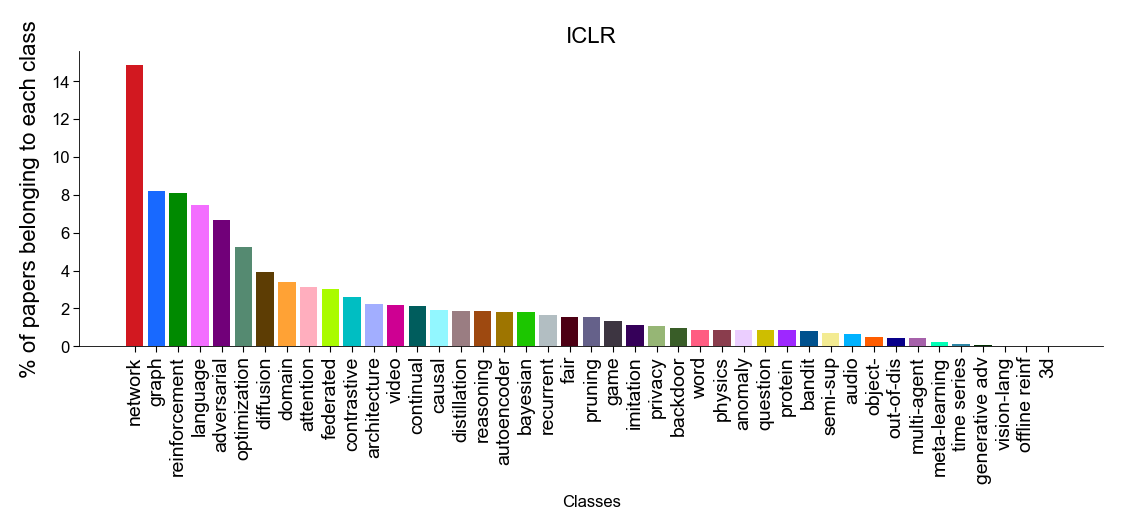

In [173]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5.5, 2.5), dpi=200)
ax.bar(
    np.arange(len(fraction_colors_iclr)),
    np.flip(np.sort(fraction_colors_iclr * 100)),
    color=unique_colors_iclr[:-1][
        np.flip(np.argsort(fraction_colors_iclr * 100))
    ],
)

ax.set_xticks(
    np.arange(len(fraction_colors_iclr)),
    labels=unique_labels[:-1][np.flip(np.argsort(fraction_colors_iclr * 100))],
    rotation="vertical",
    fontsize=7,
)
ax.set_ylabel("% of papers belonging to each class", fontsize=8)
ax.set_xlabel("Classes")
ax.set_title("ICLR")


fig.savefig(figures_path / "barplot_class_distribution_iclr_2024.png")

# Keywords exploration

In [11]:
print(f"There are {iclr2024.shape[0]} papers")

There are 24347 papers


In [12]:
n_keywords = np.array([len(elem) for elem in iclr2024.keywords])
n_keywords.shape

(24347,)

In [13]:
print(f"There are {np.sum(n_keywords == 0)} papers without any keywords")

There are 2131 papers without any keywords


In [14]:
np.amin(n_keywords)
np.amax(n_keywords)

28

In [15]:
bin_edges_n_keywords = np.arange(0, 28, 1)

In [16]:
%%time

counts_n_keywords, bins_n_keywords = np.histogram(
    n_keywords, bins=bin_edges_n_keywords
)

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 959 µs


Text(0, 0.5, '# papers')

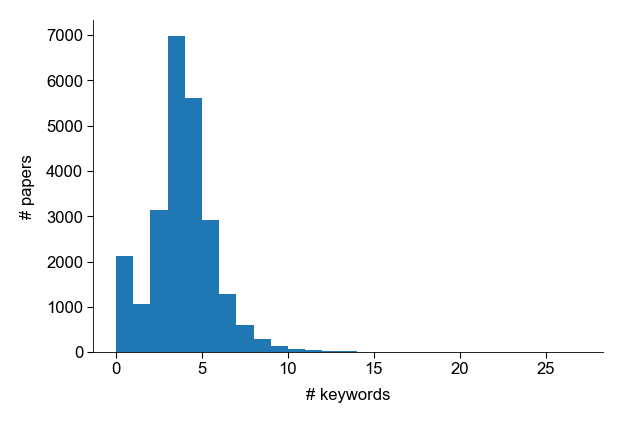

In [17]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(3, 2), dpi=200, layout="constrained")

ax.hist(bins_n_keywords[:-1], bins_n_keywords, weights=counts_n_keywords)
ax.set_xlabel("# keywords")
ax.set_ylabel("# papers")

In [254]:
unique_keywords, counts = np.unique(
    np.hstack(iclr2024.keywords), return_counts=True
)

In [255]:
np.sum(counts > 30)

300

In [257]:
n = 50
print(np.sum(counts >= n))
unique_keywords[(counts >= n) & (counts < n + 10)]

193


array(['adversarial defense', 'adversarial machine learning',
       'attention mechanism', 'autoencoders', 'autonomous driving',
       'batch normalization', 'causal discovery', 'compositionality',
       'continuous control', 'convergence', 'convex optimization',
       'deep neural network', 'density estimation', 'distillation',
       'geometric deep learning', 'hierarchical reinforcement learning',
       'hyperparameter optimization', 'implicit bias',
       'implicit regularization', 'invariance', 'inverse problems',
       'link prediction', 'multimodal learning', 'node classification',
       'offline rl', 'out-of-distribution',
       'out-of-distribution generalization', 'program synthesis',
       'question answering', 'safety', 'security',
       'spiking neural networks', 'stability', 'stochastic optimization',
       'time series forecasting', 'variance reduction',
       'vision transformers', 'zero-shot learning'], dtype='<U185')

In [21]:
print(f"There are {unique_keywords.shape[0]} different keywords")
sorted_counts_indeces = np.flip(np.argsort(counts))
sorted_counts = counts[sorted_counts_indeces]
sorted_keywords = unique_keywords[sorted_counts_indeces]

There are 25592 different keywords


In [22]:
n = 
print("Counts : ", sorted_counts[:n])
print("Keywords : ", sorted_keywords[:n])

SyntaxError: invalid syntax (310679236.py, line 1)

In [23]:
keywords_200 = sorted_keywords[:200]
sorted(keywords_200)

['active learning',
 'adversarial',
 'adversarial attack',
 'adversarial attacks',
 'adversarial defense',
 'adversarial examples',
 'adversarial learning',
 'adversarial machine learning',
 'adversarial robustness',
 'adversarial training',
 'alignment',
 'anomaly detection',
 'applications',
 'attention',
 'attention mechanism',
 'autoencoder',
 'autoencoders',
 'automl',
 'autonomous driving',
 'backdoor attack',
 'batch normalization',
 'bayesian inference',
 'bayesian optimization',
 'benchmark',
 'bert',
 'calibration',
 'catastrophic forgetting',
 'causal discovery',
 'causal inference',
 'causality',
 'classification',
 'clip',
 'clustering',
 'cnn',
 'combinatorial optimization',
 'compositionality',
 'compression',
 'computer vision',
 'continual learning',
 'continuous control',
 'contrastive learning',
 'convergence',
 'convex optimization',
 'convolutional neural network',
 'convolutional neural networks',
 'curriculum learning',
 'data augmentation',
 'dataset',
 'deep ge

In [24]:
last_elem = ""
new_keywords_groups = []
for elem in sorted(keywords_200):
    words = elem.split(" ")
    if words[0] == last_elem:
        new_keywords_groups[-1].append(elem)
    elif (words[0] == last_elem + "s") | (words[0] + "s" == last_elem):
        new_keywords_groups[-1].append(elem)
    else:
        new_keywords_groups.append([elem])
    last_elem = words[0]

In [25]:
print(len(new_keywords_groups))
new_keywords_groups

149


[['active learning'],
 ['adversarial',
  'adversarial attack',
  'adversarial attacks',
  'adversarial defense',
  'adversarial examples',
  'adversarial learning',
  'adversarial machine learning',
  'adversarial robustness',
  'adversarial training'],
 ['alignment'],
 ['anomaly detection'],
 ['applications'],
 ['attention', 'attention mechanism'],
 ['autoencoder', 'autoencoders'],
 ['automl'],
 ['autonomous driving'],
 ['backdoor attack'],
 ['batch normalization'],
 ['bayesian inference', 'bayesian optimization'],
 ['benchmark'],
 ['bert'],
 ['calibration'],
 ['catastrophic forgetting'],
 ['causal discovery', 'causal inference'],
 ['causality'],
 ['classification'],
 ['clip'],
 ['clustering'],
 ['cnn'],
 ['combinatorial optimization'],
 ['compositionality'],
 ['compression'],
 ['computer vision'],
 ['continual learning'],
 ['continuous control'],
 ['contrastive learning'],
 ['convergence'],
 ['convex optimization'],
 ['convolutional neural network', 'convolutional neural networks'],


In [ ]:
[['active learning'], # RL
 ['adversarial',
  'adversarial attack',
  'adversarial attacks',
  'adversarial defense',
  'adversarial examples',
  'adversarial learning',
  'adversarial machine learning',
  'adversarial robustness',
  'adversarial training'],
 #['alignment'],
 #['anomaly detection'],
 #['applications'],
 ['attention', 'attention mechanism'],
 ['autoencoder', 'autoencoders'],
 ['automl'],
 ['autonomous driving'],
 ['backdoor attack'],
 #['batch normalization'],
 ['bayesian inference', 'bayesian optimization'],
 #['benchmark'],
 ['bert'], # LLMs
 #['calibration'],
 #['catastrophic forgetting'],
 ['causal discovery', 'causal inference'],
 ['causality'],
 #['classification'],
 ['clip'],
 ['clustering'],
 ['cnn'], 
 ['combinatorial optimization'],
 #['compositionality'], #??
 #['compression'],
 ['computer vision'],
 ['continual learning'],
 ['continuous control'],
 ['contrastive learning'],
 #['convergence'],
 #['convex optimization'],
 ['convolutional neural network', 'convolutional neural networks'], #cnn
 #['curriculum learning'],
 ['data augmentation'],
 ['dataset'],
 ['deep generative models', 
  'deep learning',
  'deep learning theory',
  'deep neural network',
  'deep neural networks',
  'deep reinforcement learning'], #RL
 ['density estimation'],
 ['differential privacy'],
 ['diffusion', 'diffusion model', 'diffusion models'],
 ['disentanglement'],
 ['distillation'],
 ['distribution shift'],
 ['domain adaptation', 'domain generalization'],
 ['dynamical systems'],
 ['efficiency'],
 ['equivariance'],
 ['evaluation'],
 ['explainability'],
 ['explainable ai'],
 ['exploration'],
 ['fairness'],
 ['federated learning'],
 ['few-shot learning'],
 ['fine-tuning'],
 ['game theory'],
 ['gan', 'gans'],
 ['generalization'],
 ['generative adversarial network',
  'generative adversarial networks',
  'generative model',
  'generative modeling',
  'generative models'],
 ['geometric deep learning'],
 ['gnn'],
 ['gradient descent'],
 ['graph',
  'graph neural network',
  'graph neural networks',
  'graph representation learning'],
 ['hierarchical reinforcement learning'],
 ['hyperparameter optimization'],
 ['image classification', 'image generation'],
 ['imitation learning'],
 ['implicit bias', 'implicit regularization'],
 ['in-context learning'],
 ['information theory'],
 ['interpretability'],
 ['invariance'],
 ['inverse problems', 'inverse reinforcement learning'],
 ['knowledge distillation'],
 ['language model', 'language modeling', 'language models'],
 ['large language model', 'large language models'],
 ['learning theory'],
 ['lifelong learning'],
 ['link prediction'],
 ['llm'],
 ['lstm'],
 ['machine learning', 'machine translation'],
 ['meta learning'],
 ['meta-learning'],
 ['metric learning'],
 ['model compression'],
 ['model-based reinforcement learning'],
 ['multi-agent reinforcement learning'],
 ['multi-task learning'],
 ['multimodal learning'],
 ['mutual information'],
 ['natural language processing'],
 ['network pruning'],
 ['neural architecture search',
  'neural network',
  'neural networks',
  'neural tangent kernel'],
 ['neuroscience'],
 ['nlp'],
 ['node classification'],
 ['non-convex optimization'],
 ['normalizing flows'],
 ['object detection'],
 ['offline reinforcement learning', 'offline rl'],
 ['online learning'],
 ['optimal transport'],
 ['optimization'],
 ['out-of-distribution',
  'out-of-distribution detection',
  'out-of-distribution generalization'],
 ['planning'],
 ['policy gradient'],
 ['pre-training'],
 ['pretraining'],
 ['privacy'],
 ['program synthesis'],
 ['prompting'],
 ['pruning'],
 ['quantization'],
 ['question answering'],
 ['reasoning'],
 ['recurrent neural network', 'recurrent neural networks'],
 ['regression'],
 ['regularization'],
 ['reinforcement learning'],
 ['representation learning'],
 ['rnn'],
 ['robotics'],
 ['robustness'],
 ['safety'],
 ['security'],
 ['self-attention'],
 ['self-supervised learning'],
 ['semantic segmentation'],
 ['semi-supervised learning'],
 ['sgd'],
 ['sparsity'],
 ['spiking neural networks'],
 ['stability'],
 ['stochastic gradient descent', 'stochastic optimization'],
 ['supervised learning'],
 ['tabular data'],
 ['text generation'],
 ['theory'],
 ['time series', 'time series forecasting'],
 ['transfer learning'],
 ['transformer', 'transformers'],
 ['uncertainty', 'uncertainty estimation', 'uncertainty quantification'],
 ['unsupervised learning'],
 ['vae'],
 ['variance reduction'],
 ['variational autoencoder',
  'variational autoencoders',
  'variational inference'],
 ['vision transformer', 'vision transformers'],
 ['vision-language models'],
 ['zero-shot learning']]

### with frequencies

In [26]:
keywords_and_counts_200 = sorted(
    zip(sorted_keywords[:200], sorted_counts[:200])
)
keywords_and_counts_200

[('active learning', 131),
 ('adversarial', 60),
 ('adversarial attack', 121),
 ('adversarial attacks', 106),
 ('adversarial defense', 50),
 ('adversarial examples', 196),
 ('adversarial learning', 93),
 ('adversarial machine learning', 54),
 ('adversarial robustness', 241),
 ('adversarial training', 217),
 ('alignment', 68),
 ('anomaly detection', 109),
 ('applications', 80),
 ('attention', 183),
 ('attention mechanism', 53),
 ('autoencoder', 63),
 ('autoencoders', 52),
 ('automl', 68),
 ('autonomous driving', 55),
 ('backdoor attack', 47),
 ('batch normalization', 52),
 ('bayesian inference', 60),
 ('bayesian optimization', 64),
 ('benchmark', 142),
 ('bert', 77),
 ('calibration', 99),
 ('catastrophic forgetting', 89),
 ('causal discovery', 53),
 ('causal inference', 104),
 ('causality', 80),
 ('classification', 167),
 ('clip', 70),
 ('clustering', 116),
 ('cnn', 88),
 ('combinatorial optimization', 69),
 ('compositionality', 56),
 ('compression', 121),
 ('computer vision', 411),
 ('

In [27]:
last_elem = ""
new_keywords_groups = []
for elem in keywords_and_counts_200:
    print(elem)
    words = elem[0].split(" ")
    if words[0] == last_elem:
        new_keywords_groups[-1].append(elem)
    elif (words[0] == last_elem + "s") | (words[0] + "s" == last_elem):
        new_keywords_groups[-1].append(elem)
    else:
        new_keywords_groups.append([elem])
    last_elem = words[0]

('active learning', 131)
('adversarial', 60)
('adversarial attack', 121)
('adversarial attacks', 106)
('adversarial defense', 50)
('adversarial examples', 196)
('adversarial learning', 93)
('adversarial machine learning', 54)
('adversarial robustness', 241)
('adversarial training', 217)
('alignment', 68)
('anomaly detection', 109)
('applications', 80)
('attention', 183)
('attention mechanism', 53)
('autoencoder', 63)
('autoencoders', 52)
('automl', 68)
('autonomous driving', 55)
('backdoor attack', 47)
('batch normalization', 52)
('bayesian inference', 60)
('bayesian optimization', 64)
('benchmark', 142)
('bert', 77)
('calibration', 99)
('catastrophic forgetting', 89)
('causal discovery', 53)
('causal inference', 104)
('causality', 80)
('classification', 167)
('clip', 70)
('clustering', 116)
('cnn', 88)
('combinatorial optimization', 69)
('compositionality', 56)
('compression', 121)
('computer vision', 411)
('continual learning', 339)
('continuous control', 58)
('contrastive learning',

In [130]:
print(len(new_keywords_groups))
new_keywords_groups

149


[[('active learning', 131)],
 [('adversarial', 60),
  ('adversarial attack', 121),
  ('adversarial attacks', 106),
  ('adversarial defense', 50),
  ('adversarial examples', 196),
  ('adversarial learning', 93),
  ('adversarial machine learning', 54),
  ('adversarial robustness', 241),
  ('adversarial training', 217)],
 [('alignment', 68)],
 [('anomaly detection', 109)],
 [('applications', 80)],
 [('attention', 183), ('attention mechanism', 53)],
 [('autoencoder', 63), ('autoencoders', 52)],
 [('automl', 68)],
 [('autonomous driving', 55)],
 [('backdoor attack', 47)],
 [('batch normalization', 52)],
 [('bayesian inference', 60), ('bayesian optimization', 64)],
 [('benchmark', 142)],
 [('bert', 77)],
 [('calibration', 99)],
 [('catastrophic forgetting', 89)],
 [('causal discovery', 53), ('causal inference', 104)],
 [('causality', 80)],
 [('classification', 167)],
 [('clip', 70)],
 [('clustering', 116)],
 [('cnn', 88)],
 [('combinatorial optimization', 69)],
 [('compositionality', 56)],
 

In [ ]:
manual_keywords_groups = [
 [('active learning', 131)], #RL
 [('adversarial', 60),
  ('adversarial attack', 121),
  ('adversarial attacks', 106),
  ('adversarial defense', 50),
  ('adversarial examples', 196),
  ('adversarial learning', 93),
  ('adversarial machine learning', 54),
  ('adversarial robustness', 241),
  ('adversarial training', 217)],
 #[('alignment', 68)],
 #[('anomaly detection', 109)],
 #[('applications', 80)],
 [('attention', 183), ('attention mechanism', 53)], #LLMS
 [('autoencoder', 63), ('autoencoders', 52),
  ('vae', 71)
  ('variational autoencoder', 93),
  ('variational autoencoders', 83),
  ('variational inference', 194)], # vaes
 #[('automl', 68)],
 [('autonomous driving', 55)],
 [('backdoor attack', 47)], # probably adversarial
 #[('batch normalization', 52)],
 [('bayesian inference', 60), ('bayesian optimization', 64)],
 #[('benchmark', 142)],
 [('bert', 77)], #LLMS
 #[('calibration', 99)],
 [('catastrophic forgetting', 89)], #LLMS, too specific?
 [('causal discovery', 53), ('causal inference', 104)],
 [('causality', 80)], # join with above ?
 #[('classification', 167)],
 #[('clip', 70)],
 [('clustering', 116)],
 [('cnn', 88)],
 #[('combinatorial optimization', 69)],
 #[('compositionality', 56)],
 [('compression', 121)], #join with model compression ?
 [('computer vision', 411)], # too general ? 
# [('continual learning', 339)],
 #[('continuous control', 58)],
 [('contrastive learning', 344)],
 #[('convergence', 54)],
 #[('convex optimization', 57)],
 [('convolutional neural network', 76),
  ('convolutional neural networks', 130)], #cnn
 [('curriculum learning', 76)],
 [('data augmentation', 190)],
 #[('dataset', 64)],
 [('deep generative models', 77), # generative models
  #('deep learning', 1950), # too general
  ('deep learning theory', 98),
  ('deep neural network', 51),
  ('deep neural networks', 137),
  ('deep reinforcement learning', 298)], # RL
 #[('density estimation', 51)],
 #[('differential privacy', 154)],
 [('diffusion', 69), ('diffusion model', 167), ('diffusion models', 280)],
 [('disentanglement', 93)],
 [('distillation', 56)],
 [('distribution shift', 96)], # maybe with ood things
 [('domain adaptation', 176), ('domain generalization', 124)],
 [('dynamical systems', 68)],
 #[('efficiency', 62)],
 #[('equivariance', 80)],
 #[('evaluation', 89)],
 [('explainability', 131)],
 [('explainable ai', 92)], # join with above
 #[('exploration', 151)],
 [('fairness', 182)],
 [('federated learning', 485)],
 [('few-shot learning', 218)], #RL
 [('fine-tuning', 90)], # ? 
 [('game theory', 62)],
 [('gan', 168), ('gans', 91)],
 #[('generalization', 413)],
 [('generative adversarial network', 70), # gans
  ('generative adversarial networks', 190), #gans
  ('generative model', 182),
  ('generative modeling', 69),
  ('generative models', 390)],
 [('geometric deep learning', 51)],
 [('gnn', 64)],
 #[('gradient descent', 86)],
 [('graph', 48),
  ('graph neural network', 230),
  ('graph neural networks', 563),
  ('graph representation learning', 85)], # gnn
 [('hierarchical reinforcement learning', 53)], # RL
 [('hyperparameter optimization', 57)],# ?
 [('image classification', 177), ('image generation', 60)], # split and maybe the second to generative models
 [('imitation learning', 171)],
 [('implicit bias', 56), ('implicit regularization', 54)],
 [('in-context learning', 105)], # RL
 [('information theory', 106)],
 [('interpretability', 356)], # explainable ai
 #[('invariance', 55)],
 [('inverse problems', 53), ('inverse reinforcement learning', 63)],# split and second with RL
 [('knowledge distillation', 211)], #LLMs
 [('language model', 105),
  ('language modeling', 85),
  ('language models', 151)], #LLMS
 [('large language model', 210), ('large language models', 447)], #LLMS
 [('learning theory', 83)],
 [('lifelong learning', 82)], # RL
 #[('link prediction', 51)],
 [('llm', 80)],
 [('lstm', 66)], #RNNs
 [('machine learning', 304), ('machine translation', 91)], # split and delete first
 [('meta learning', 121)],
 [('meta-learning', 301)], # join
 #[('metric learning', 63)],
 [('model compression', 135)],
 [('model-based reinforcement learning', 111)], # RL
 [('multi-agent reinforcement learning', 162)], # RL
 [('multi-task learning', 141)], # RL
 [('multimodal learning', 58)], # RL
 #[('mutual information', 75)],
 [('natural language processing', 433)], #join with nlp but maybe eliminate becase too general ?
 #[('network pruning', 48)],
 [('neural architecture search', 180),
  ('neural network', 150),
  ('neural networks', 385),
  ('neural tangent kernel', 81)], # split and eliminate last
 [('neuroscience', 82)],
 [('nlp', 166)],
 #[('node classification', 56)],
 [('non-convex optimization', 66)], #optimization ?
 #[('normalizing flows', 49)],
 [('object detection', 125)], # computer vision
 [('offline reinforcement learning', 150), ('offline rl', 55)], # RL
 [('online learning', 80)], # RL
 [('optimal transport', 165)],
 [('optimization', 410)],
 [('out-of-distribution', 53),
  ('out-of-distribution detection', 92),
  ('out-of-distribution generalization', 59)],
 #[('planning', 87)],
 #[('policy gradient', 62)], #RL but too specific
 [('pre-training', 88)],
 [('pretraining', 60)], # join with above
 #[('privacy', 99)],
 #[('program synthesis', 56)],
 [('prompting', 48)], #LLMs
 [('pruning', 140)],
 [('quantization', 121)],
 #[('question answering', 59)],
 #[('reasoning', 85)],
 [('recurrent neural network', 48), ('recurrent neural networks', 114)],
 [('regression', 66)],
 [('regularization', 185)],
 [('reinforcement learning', 1608),
  ('zero-shot learning', 56),
  
  ], # too general?
 #[('representation learning', 838)], # too general
 [('rnn', 65)],
 [('robotics', 103)],
 [('robustness', 411)],
 #[('safety', 51)],
 #[('security', 56)],
 [('self-attention', 73)], # LLMs/ attention
 #[('self-supervised learning', 473)], # join with CL?
 [('semantic segmentation', 92)],
 #[('semi-supervised learning', 253)],
 [('sgd', 86)], # optimization
 #[('sparsity', 108)],
 #[('spiking neural networks', 55)],
 #[('stability', 56)],
 [('stochastic gradient descent', 77), ('stochastic optimization', 56)],
 #[('supervised learning', 141)],
 #[('tabular data', 68)],
 [('text generation', 66)],
 #[('theory', 120)],
 [('time series', 129), ('time series forecasting', 54)],
 #[('transfer learning', 388)], # too general
 [('transformer', 340), ('transformers', 261)], # add to attention
 [('uncertainty', 108),
  ('uncertainty estimation', 95),
  ('uncertainty quantification', 76)],
 #[('unsupervised learning', 427)],
 #[('variance reduction', 50)],
 [('vision transformer', 98), ('vision transformers', 51)],
 [('vision-language models', 48)], # add clip
 ]

In [167]:
manual_keywords_groups = [
    ###### ADVERSARIAL
    [
        ("adversarial", 60),
        ("adversarial attack", 121),
        ("adversarial attacks", 106),
        ("adversarial defense", 50),
        ("adversarial examples", 196),
        ("adversarial learning", 93),
        ("adversarial machine learning", 54),
        ("adversarial robustness", 241),
        ("adversarial training", 217),
    ],
    ###### TRANSFORMERS
    [
        ("attention", 183),
        ("attention mechanism", 53),
        ("transformer", 340),
        ("transformers", 261),
        ("self-attention", 73),
        ("bert", 77),
    ],
    ###### AUTOENCODERS
    [
        ("autoencoder", 63),
        ("autoencoders", 52),
        ("vae", 71),
        ("variational autoencoder", 93),
        ("variational autoencoders", 83),
        ("variational inference", 194),
    ],
    [("bayesian inference", 60)],
    [("causal discovery", 53), ("causal inference", 104), ("causality", 80)],
    [("clustering", 116)],
    [("compression", 121), ("model compression", 135)],
    ###### COMPUTER VISION
    [
        ("computer vision", 411),
        ("object detection", 125),
    ],
    [("autonomous driving", 55)],
    ###### CL
    [("contrastive learning", 344)],
    ###### CNNs
    [
        ("convolutional neural network", 76),
        ("convolutional neural networks", 130),
        ("cnn", 88),
    ],
    [("data augmentation", 190)],
    ###### DEEP LEARNING THEORY
    [  # ('deep learning', 1950),
        ("deep learning theory", 98),
        # ("deep neural network", 51),
        # ("deep neural networks", 137),
    ],
    ###### DIFFUSION MODELS
    [("diffusion", 69), ("diffusion model", 167), ("diffusion models", 280)],
    [("disentanglement", 93)],
    [("dynamical systems", 68)],
    ###### EXPLAINABLE AI
    [("explainability", 131), ("explainable ai", 92)],
    [("interpretability", 356)],
    [("fairness", 182)],
    [("federated learning", 485)],
    [("game theory", 62)],
    ###### GANS
    [
        ("generative adversarial network", 70),
        ("generative adversarial networks", 190),
        ("gan", 168),
        ("gans", 91),
    ],
    ###### GENERATIVE MODELS
    [
        ("generative model", 182),
        ("generative modeling", 69),
        ("generative models", 390),
        ("deep generative models", 77),
        ("image generation", 60),
        ("text generation", 66),
    ],
    [("generalization", 413), ("domain generalization", 124)],
    ###### GRAPH
    [
        ("graph", 48),
        ("graph neural network", 230),
        ("graph neural networks", 563),
        ("graph representation learning", 85),
        ("gnn", 64),
        ("geometric deep learning", 51),
    ],
    # [('implicit bias', 56)],
    [("information theory", 106)],
    # [('learning theory', 83)],
    ###### LLMS
    [
        ("llm", 80),
        ("large language model", 210),
        ("large language models", 447),
        ("knowledge distillation", 211),
        ("prompting", 48),
    ],
    [
        ("natural language processing", 433),
        ("nlp", 166),
        ("language model", 105),
        ("language models", 151),
        ("language modeling", 85),
        ("machine translation", 91),
        ("question answering", 59),
        ("reasoning", 85),
    ],
    [("catastrophic forgetting", 89)],
    ###### META-LEARNING
    [("meta learning", 121), ("meta-learning", 301)],
    [("network pruning", 48), ("pruning", 140)],
    [("neural architecture search", 180)],
    [("neuroscience", 82)],
    [("optimal transport", 165)],
    ###### OPTIMIZATION
    [
        ("stochastic gradient descent", 77),
        ("stochastic optimization", 56),
        ("sgd", 86),
        ("optimization", 410),
        ("non-convex optimization", 66),
        ("convex optimization", 57),
        ("gradient descent", 86),
        ("combinatorial optimization", 69),
        ("bayesian optimization", 64),
    ],
    ###### OUT-OF-DISTRIBUTION
    [
        ("out-of-distribution", 53),
        ("out-of-distribution detection", 92),
        ("out-of-distribution generalization", 59),
        ("distribution shift", 96),
    ],
    ###### RNNs
    [
        ("rnn", 65),
        ("recurrent neural network", 48),
        ("recurrent neural networks", 114),
        ("lstm", 66),
    ],
    [("regularization", 185), ("implicit regularization", 54)],
    ###### RL
    [("reinforcement learning", 1608)],
    [("active learning", 131)],
    [("model-based reinforcement learning", 111)],
    [("multi-agent reinforcement learning", 162)],
    [("multi-task learning", 141)],
    [("multimodal learning", 58)],
    [("inverse reinforcement learning", 63)],
    [("hierarchical reinforcement learning", 53)],
    [("imitation learning", 171)],
    [("offline reinforcement learning", 150), ("offline rl", 55)],
    [("online learning", 80)],
    [
        ("continual learning", 339),
        ("lifelong learning", 82),
    ],  # ask Dmitry/check: do you think they can be grouped into one keyword?
    ### NOT RL
    [
        ("in-context learning", 105),
        ("zero-shot learning", 56),
    ],  # ask Dmitry/check: do you think they can be grouped into one keyword?
    [("few-shot learning", 218)],
    [("robotics", 103)],
    [("robustness", 411)],
    [("self-supervised learning", 473)],
    [("semantic segmentation", 92)],
    [("semi-supervised learning", 253)],
    [("spiking neural networks", 55)],
    [("time series", 129), ("time series forecasting", 54)],
    ###### TRANSFER LEARNING
    [
        ("transfer learning", 388),
        ("domain adaptation", 176),
        ("fine-tuning", 90),
    ],
    ###### UNCERTAINTY
    [
        ("uncertainty", 108),
        ("uncertainty estimation", 95),
        ("uncertainty quantification", 76),
    ],
    [("vision transformer", 98), ("vision transformers", 51)],
    [("vision-language models", 48), ("clip", 70)],
]

In [168]:
print(len(manual_keywords_groups))

63


In [175]:
# CORRECTED
not_used_keywords = []
for i, elem in enumerate(np.vstack(keywords_and_counts_200)):
    # print(elem)
    if elem[0] in np.vstack(manual_keywords_groups):
        continue
    else:
        not_used_keywords.append(elem)
        # print(elem)
        print(keywords_and_counts_200[i])

('alignment', 68)
('anomaly detection', 109)
('applications', 80)
('automl', 68)
('backdoor attack', 47)
('batch normalization', 52)
('benchmark', 142)
('calibration', 99)
('classification', 167)
('compositionality', 56)
('continuous control', 58)
('convergence', 54)
('curriculum learning', 76)
('dataset', 64)
('deep learning', 1950)
('deep neural network', 51)
('deep neural networks', 137)
('deep reinforcement learning', 298)
('density estimation', 51)
('differential privacy', 154)
('distillation', 56)
('efficiency', 62)
('equivariance', 80)
('evaluation', 89)
('exploration', 151)
('hyperparameter optimization', 57)
('image classification', 177)
('implicit bias', 56)
('invariance', 55)
('inverse problems', 53)
('learning theory', 83)
('link prediction', 51)
('machine learning', 304)
('metric learning', 63)
('mutual information', 75)
('neural network', 150)
('neural networks', 385)
('neural tangent kernel', 81)
('node classification', 56)
('normalizing flows', 49)
('planning', 87)
('po

In [ ]:
# FIRST KICKED OUT WORDS LIST (INCOMPLETE)
# ('anomaly detection', 109)
# ('backdoor attack', 47)
# ('benchmark', 142)
# ('calibration', 99)
# ('deep learning', 1950)
# ('deep neural networks', 137)
# ('deep reinforcement learning', 298)
# ('differential privacy', 154)
# ('image classification', 177)
# ('machine learning', 304)
# ('mutual information', 75)
# ('neural networks', 385)
# ('neural tangent kernel', 81)
# ('normalizing flows', 49)
# ('planning', 87)
# ('privacy', 99)
# ('representation learning', 838)
# ('theory', 120)
# ('unsupervised learning', 427)

In [ ]:
# final sanity check
len(not_used_keywords) + len(np.vstack(manual_keywords_groups))

200

#### Create list with the not-included kicked out words in the document

In [203]:
document = [
    ###### ADVERSARIAL
    [
        ("adversarial", 60),
        ("adversarial attack", 121),
        ("adversarial attacks", 106),
        ("adversarial defense", 50),
        ("adversarial examples", 196),
        ("adversarial learning", 93),
        ("adversarial machine learning", 54),
        ("adversarial robustness", 241),
        ("adversarial training", 217),
    ],
    ###### TRANSFORMERS
    [
        ("attention", 183),
        ("attention mechanism", 53),
        ("transformer", 340),
        ("transformers", 261),
        ("self-attention", 73),
        ("bert", 77),
    ],
    ###### AUTOENCODERS
    [
        ("autoencoder", 63),
        ("autoencoders", 52),
        ("vae", 71),
        ("variational autoencoder", 93),
        ("variational autoencoders", 83),
        ("variational inference", 194),
    ],
    [("anomaly detection", 109)],
    [("bayesian inference", 60)],
    [("causal discovery", 53), ("causal inference", 104), ("causality", 80)],
    [("clustering", 116)],
    [("compression", 121), ("model compression", 135)],
    ###### COMPUTER VISION
    [
        ("computer vision", 411),
        ("object detection", 125),
    ],
    [("autonomous driving", 55)],
    ###### CL
    [("contrastive learning", 344)],
    ###### CNNs
    [
        ("convolutional neural network", 76),
        ("convolutional neural networks", 130),
        ("cnn", 88),
    ],
    [("data augmentation", 190)],
    ###### DEEP LEARNING THEORY
    [
        ("deep learning", 1950),
        ("deep learning theory", 98),
        ("deep neural network", 51),
        ("deep neural networks", 137),
    ],
    ###### DIFFUSION MODELS
    [("diffusion", 69), ("diffusion model", 167), ("diffusion models", 280)],
    [("disentanglement", 93)],
    [("dynamical systems", 68)],
    ###### EXPLAINABLE AI
    [("explainability", 131), ("explainable ai", 92)],
    [("interpretability", 356)],
    [("fairness", 182)],
    [("federated learning", 485)],
    [("game theory", 62)],
    ###### GANS
    [
        ("generative adversarial network", 70),
        ("generative adversarial networks", 190),
        ("gan", 168),
        ("gans", 91),
    ],
    ###### GENERATIVE MODELS
    [
        ("generative model", 182),
        ("generative modeling", 69),
        ("generative models", 390),
        ("deep generative models", 77),
        ("image generation", 60),
        ("text generation", 66),
    ],
    [("generalization", 413), ("domain generalization", 124)],
    ###### GRAPH
    [
        ("graph", 48),
        ("graph neural network", 230),
        ("graph neural networks", 563),
        ("graph representation learning", 85),
        ("gnn", 64),
        ("geometric deep learning", 51),
    ],
    [("implicit bias", 56)],
    [("information theory", 106)],
    [("learning theory", 83)],
    ###### LLMS
    [
        ("llm", 80),
        ("large language model", 210),
        ("large language models", 447),
        ("prompting", 48),
    ],
    [("knowledge distillation", 211)],
    [
        ("natural language processing", 433),
        ("nlp", 166),
        ("language model", 105),
        ("language models", 151),
        ("language modeling", 85),
        ("machine translation", 91),
        ("question answering", 59),
        ("reasoning", 85),
    ],
    [("catastrophic forgetting", 89)],
    ###### META-LEARNING
    [("meta learning", 121), ("meta-learning", 301)],
    [("network pruning", 48), ("pruning", 140)],
    [("neural architecture search", 180)],
    [("neuroscience", 82)],
    [("optimal transport", 165)],
    ###### OPTIMIZATION
    [
        ("stochastic gradient descent", 77),
        ("stochastic optimization", 56),
        ("sgd", 86),
        ("optimization", 410),
        ("non-convex optimization", 66),
        ("convex optimization", 57),
        ("gradient descent", 86),
        ("combinatorial optimization", 69),
        ("bayesian optimization", 64),
    ],
    ###### OUT-OF-DISTRIBUTION
    [
        ("out-of-distribution", 53),
        ("out-of-distribution detection", 92),
        ("out-of-distribution generalization", 59),
        ("distribution shift", 96),
    ],
    ###### RNNs
    [
        ("rnn", 65),
        ("recurrent neural network", 48),
        ("recurrent neural networks", 114),
        ("lstm", 66),
    ],
    [("regularization", 185), ("implicit regularization", 54)],
    ###### RL
    [("reinforcement learning", 1608)],
    [("active learning", 131)],
    [("model-based reinforcement learning", 111)],
    [("multi-agent reinforcement learning", 162)],
    [("multi-task learning", 141)],
    [("multimodal learning", 58)],
    [("inverse reinforcement learning", 63)],
    [("hierarchical reinforcement learning", 53)],
    [("imitation learning", 171)],
    [("offline reinforcement learning", 150), ("offline rl", 55)],
    [("online learning", 80)],
    [
        ("continual learning", 339),
        ("lifelong learning", 82),
    ],  # ask Dmitry/check: do you think they can be grouped into one keyword?
    ### NOT RL
    [
        ("in-context learning", 105),
        ("zero-shot learning", 56),
    ],
    [("few-shot learning", 218)],
    [("robotics", 103)],
    [("robustness", 411)],
    [("self-supervised learning", 473)],
    [("semantic segmentation", 92)],
    [("semi-supervised learning", 253)],
    [("spiking neural networks", 55)],
    [("time series", 129), ("time series forecasting", 54)],
    ###### TRANSFER LEARNING
    [
        ("transfer learning", 388),
        ("domain adaptation", 176),
        ("fine-tuning", 90),
    ],
    ###### UNCERTAINTY
    [
        ("uncertainty", 108),
        ("uncertainty estimation", 95),
        ("uncertainty quantification", 76),
    ],
    [("vision transformer", 98), ("vision transformers", 51)],
    [("vision-language models", 48), ("clip", 70)],
    ###---
    [("anomaly detection", 109)],
    [("backdoor attack", 47)],
    [("benchmark", 142)],
    [("calibration", 99)],
    [("deep learning", 1950)],
    [("deep neural networks", 137)],
    [("deep reinforcement learning", 298)],
    [("differential privacy", 154)],
    [("image classification", 177)],
    [("machine learning", 304)],
    [("mutual information", 75)],
    [("neural networks", 385)],
    [("neural tangent kernel", 81)],
    [("normalizing flows", 49)],
    [("planning", 87)],
    [("privacy", 99)],
    [("representation learning", 838)],
    [("theory", 120)],
    [("unsupervised learning", 427)],
]
###### KICKED OUT ONES

In [252]:
not_used_keywords_2 = []
used_keywords = []

for i, elem in enumerate(np.vstack(keywords_and_counts_200)):
    # print(i, elem)
    if elem[0] in np.vstack(document):
        used_keywords.append(list(elem))
    else:
        not_used_keywords_2.append(list(elem))
        # print(elem)
        print(keywords_and_counts_200[i])

('alignment', 68)
('applications', 80)
('automl', 68)
('batch normalization', 52)
('classification', 167)
('compositionality', 56)
('continuous control', 58)
('convergence', 54)
('curriculum learning', 76)
('dataset', 64)
('density estimation', 51)
('distillation', 56)
('efficiency', 62)
('equivariance', 80)
('evaluation', 89)
('exploration', 151)
('hyperparameter optimization', 57)
('invariance', 55)
('inverse problems', 53)
('link prediction', 51)
('metric learning', 63)
('neural network', 150)
('node classification', 56)
('policy gradient', 62)
('pre-training', 88)
('pretraining', 60)
('program synthesis', 56)
('quantization', 121)
('regression', 66)
('safety', 51)
('security', 56)
('sparsity', 108)
('stability', 56)
('supervised learning', 141)
('tabular data', 68)
('variance reduction', 50)


In [ ]:
###### ADDITIONAL LIST OF KICKED OUT KEYWORDS 
###### (not appearing in list above or commented out inside `manual_keywords_groups`)
# ('alignment', 68)
# ('applications', 80)
# ('automl', 68)
# ('batch normalization', 52)
# ('classification', 167)
# ('compositionality', 56)
# ('continuous control', 58)
# ('convergence', 54)
# ('curriculum learning', 76)
# ('dataset', 64)
# ('density estimation', 51)
# ('distillation', 56)
# ('efficiency', 62)
# ('equivariance', 80)
# ('evaluation', 89)
# ('exploration', 151)
# ('hyperparameter optimization', 57)
# ('invariance', 55)
# ('inverse problems', 53)
# ('link prediction', 51)
# ('metric learning', 63)
# ('neural network', 150)
# ('node classification', 56)
# ('policy gradient', 62)
# ('pre-training', 88)
# ('pretraining', 60)
# ('program synthesis', 56)
# ('quantization', 121)
# ('regression', 66)
# ('safety', 51)
# ('security', 56)
# ('sparsity', 108)
# ('stability', 56)
# ('supervised learning', 141)
# ('tabular data', 68)
# ('variance reduction', 50)

In [251]:
len(np.vstack(document)) + len(not_used_keywords_2)
# this does not add up to 200 because in document there are 3 repeated keywords, see below

203

In [247]:
print(len(np.vstack(document)))
print(len(np.unique(np.vstack(document)[:, 0])))
shit, counts = np.unique(np.vstack(document)[:, 0], return_counts=True)

167
164


In [248]:
shit[counts > 1]

array(['anomaly detection', 'deep learning', 'deep neural networks'],
      dtype='<U35')

## Test of how to asign labels

In [52]:
import itertools

In [53]:
test_keywords_and_freqs = [
    [("burdeos", 5), ("BURDEOS", 10)],  # "color burdeos"
    [("verdes", 13), ("VERDES", 7)],  # "color verde"
    [("rojos", 20)],  # "color rojo"
    [("azul", 5)],  # "color azul"
]

In [54]:
dict_keyword_to_label = {
    "burdeos": "color burdeos",
    "BURDEOS": "color burdeos",
    "verdes": "color verde",
    "VERDES": "color verde",
    "rojos": "color rojo",
    "azul": "color azul",
}

In [55]:
np.vstack(test_keywords_and_freqs)

array([['burdeos', '5'],
       ['BURDEOS', '10'],
       ['verdes', '13'],
       ['VERDES', '7'],
       ['rojos', '20'],
       ['azul', '5']], dtype='<U21')

In [56]:
list_keywords_and_freqs = list(
    itertools.chain.from_iterable(test_keywords_and_freqs)
)
list_keywords_and_freqs

[('burdeos', 5),
 ('BURDEOS', 10),
 ('verdes', 13),
 ('VERDES', 7),
 ('rojos', 20),
 ('azul', 5)]

In [57]:
# list_keywords_and_freqs.sort(key=lambda a: a[1])
# list_keywords_and_freqs

In [58]:
# np.vstack(test_keywords_and_freqs)  # [:, 1]
# dict_freqs = dict(
#     zip(
#         np.vstack(test_keywords_and_freqs)[:, 0],
#         np.vstack(test_keywords_and_freqs)[:, 1],
#     )
# )
# dict_freqs = dict(
#     zip(
#         np.vstack(test_keywords_and_freqs)[:, 0],
#         list(itertools.chain.from_iterable(test_keywords_and_freqs)),
#     )
# )

In [59]:
dict_freqs = dict(list(itertools.chain.from_iterable(test_keywords_and_freqs)))
# dict_freqs_swap = {value: key for key, value in dict_freqs.items()}
dict_freqs

{'burdeos': 5,
 'BURDEOS': 10,
 'verdes': 13,
 'VERDES': 7,
 'rojos': 20,
 'azul': 5}

In [60]:
dict_freqs["unlabeled"] = 1e9
dict_freqs

{'burdeos': 5,
 'BURDEOS': 10,
 'verdes': 13,
 'VERDES': 7,
 'rojos': 20,
 'azul': 5,
 'unlabeled': 1000000000.0}

In [61]:
test_data = [
    ["rojos", "burdeos"],  # "color rojo"
    ["VERDES", "verdes", "amarillos"],  # "color verde"
    ["azul"],  # "color azul"
    ["BURDEOS"],  # "color burdeos"
    [],
    [""],
    ["otros"],  # "unlabeled"
]

In [62]:
test_data

[['rojos', 'burdeos'],
 ['VERDES', 'verdes', 'amarillos'],
 ['azul'],
 ['BURDEOS'],
 [],
 [''],
 ['otros']]

In [63]:
test_data_without_empty = [
    ["unlabeled"] if elem == [] else elem for elem in test_data
]
test_data_without_empty

[['rojos', 'burdeos'],
 ['VERDES', 'verdes', 'amarillos'],
 ['azul'],
 ['BURDEOS'],
 ['unlabeled'],
 [''],
 ['otros']]

In [64]:
# elem = test_data[0]
for elem in test_data_without_empty:
    print(elem)

    elem_filtered = [
        kywrd if kywrd in set(dict_freqs.keys()) else "unlabeled"
        for kywrd in elem
    ]
    print(elem_filtered)
    freqs = np.vectorize(dict_freqs.get)(elem_filtered)

    chosen_keyword = elem_filtered[np.argmin(freqs)]
    print(chosen_keyword)
    print("---------")

['rojos', 'burdeos']
['rojos', 'burdeos']
burdeos
---------
['VERDES', 'verdes', 'amarillos']
['VERDES', 'verdes', 'unlabeled']
VERDES
---------
['azul']
['azul']
azul
---------
['BURDEOS']
['BURDEOS']
BURDEOS
---------
['unlabeled']
['unlabeled']
unlabeled
---------
['']
['unlabeled']
unlabeled
---------
['otros']
['unlabeled']
unlabeled
---------


In [76]:
import seaborn as sns

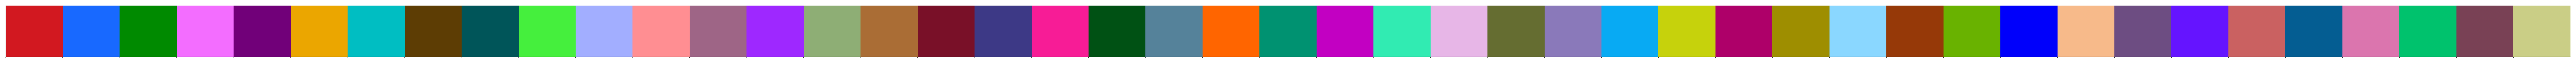

In [93]:
%matplotlib inline
palette = glasbey.create_palette(
    palette_size=len(final_keywords_groups),
    lightness_bounds=(20, 75),
    chroma_bounds=(30, 90),
)
palette
sns.palplot(palette)

In [ ]:
unique_labels = np.unique(list(dict_keyword_to_label.values()))

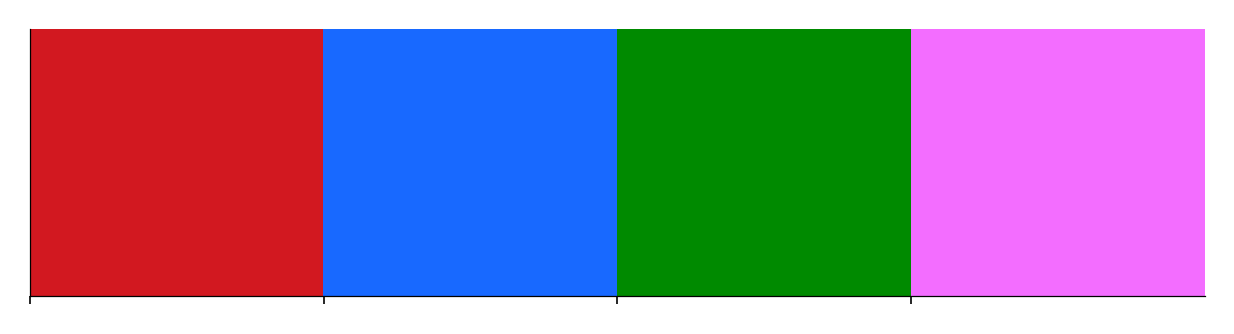

In [94]:
%matplotlib inline
palette = glasbey.create_palette(
    palette_size=len(unique_labels),
    lightness_bounds=(20, 75),
    chroma_bounds=(30, 90),
)
palette
sns.palplot(palette)

In [98]:
dict_color_to_keywords = dict(zip(unique_labels, palette))
dict_color_to_keywords["unlabeled"] = "lightgrey"
dict_color_to_keywords

{'color azul': '#d21820',
 'color burdeos': '#1869ff',
 'color rojo': '#008a00',
 'color verde': '#f36dff',
 'unlabeled': 'lightgrey'}

In [97]:
def assign_keywords(
    data, keywords_and_freqs, dict_keyword_to_label, dict_color_legend=None
):
    """
    data: list with lists of keywords
    dict_freqs: dict of freqs
    """

    # prepare dict_freqs
    dict_freqs = dict(list(itertools.chain.from_iterable(keywords_and_freqs)))
    dict_freqs[
        "unlabeled"
    ] = 1e9  # assign very large value to unlabeled for argmax

    # clean empty lists of keywords from the data
    data_without_empty = [
        ["unlabeled"] if elem == [] else elem for elem in data
    ]

    # choose keywords for each paper
    # chosen_keywords = []  # np.empty(len(data_without_empty))
    chosen_keywords = np.empty(len(data_without_empty), dtype="<U9")
    for i, list_keywords in enumerate(data_without_empty):
        list_keywords_filtered = [
            elem if elem in set(dict_freqs.keys()) else "unlabeled"
            for elem in list_keywords
        ]

        freqs = np.vectorize(dict_freqs.get)(list_keywords_filtered)

        chosen_keyword = list_keywords_filtered[np.argmin(freqs)]
        chosen_keywords[i] = chosen_keyword
        # chosen_keywords.append(chosen_keyword)

    # chosen_keywords = np.array(chosen_keywords)
    # print(chosen_keywords)
    # print(type(chosen_keywords))

    # map chosen keywords to labels
    dict_keyword_to_label["unlabeled"] = "unlabeled"
    labels = np.vectorize(dict_keyword_to_label.get)(chosen_keywords)

    if dict_color_legend is not None:
        # colors
        colors = np.vectorize(dict_color_legend.get)(labels)

        return labels, colors
    return chosen_keywords

In [99]:
assign_keywords(
    test_data,
    test_keywords_and_freqs,
    dict_keyword_to_label,
    dict_color_legend=dict_color_to_keywords,
)

(array(['color burdeos', 'color verde', 'color azul', 'color burdeos',
        'unlabeled', 'unlabeled', 'unlabeled'], dtype='<U13'),
 array(['#1869ff', '#f36dff', '#d21820', '#1869ff', 'lightgrey',
        'lightgrey', 'lightgrey'], dtype='<U9'))

In [39]:
print(test_data)

[['rojos', 'burdeos'], ['VERDES', 'verdes', 'amarillos'], ['azul'], ['BURDEOS'], [], [''], ['otros']]


## Final list of keywords

In [7]:
final_keywords_groups = [
    ###### ADVERSARIAL
    [
        ("adversarial", 60),
        ("adversarial attack", 121),
        ("adversarial attacks", 106),
        ("adversarial defense", 50),
        ("adversarial examples", 196),
        ("adversarial learning", 93),
        ("adversarial machine learning", 54),
        ("adversarial robustness", 241),
        ("adversarial training", 217),
    ],
    ###### TRANSFORMERS
    [
        ("attention", 183),
        ("attention mechanism", 53),
        ("transformer", 340),
        ("transformers", 261),
        ("self-attention", 73),
        # ("bert", 77),
    ],
    ###### AUTOENCODERS
    [
        ("autoencoder", 63),
        ("autoencoders", 52),
        ("vae", 71),
        ("variational autoencoder", 93),
        ("variational autoencoders", 83),
        # ("variational inference", 194),
    ],
    [("anomaly detection", 109)],
    # [("bayesian inference", 60)],
    [("causal discovery", 53), ("causal inference", 104), ("causality", 80)],
    [("clustering", 116)],
    [("compression", 121), ("model compression", 135)],
    ###### COMPUTER VISION
    [
        # ("computer vision", 411),
        ("object detection", 125),
    ],
    # [("autonomous driving", 55)],
    ###### CL
    [("contrastive learning", 344)],
    ###### CNNs
    [
        ("convolutional neural network", 76),
        ("convolutional neural networks", 130),
        ("cnn", 88),
    ],
    # [("data augmentation", 190)],
    ###### DEEP LEARNING THEORY
    # [  # ('deep learning', 1950),
    #     # ("deep learning theory", 98),
    #     # ("deep neural network", 51),
    #     # ("deep neural networks", 137),
    # ],
    ###### DIFFUSION MODELS
    [("diffusion", 69), ("diffusion model", 167), ("diffusion models", 280)],
    # [("disentanglement", 93)],
    # [("dynamical systems", 68)],
    ###### EXPLAINABLE AI
    [("explainability", 131), ("explainable ai", 92)],
    [("interpretability", 356)],
    [("fairness", 182)],
    [("federated learning", 485)],
    # [("game theory", 62)],
    ###### GANS
    [
        ("generative adversarial network", 70),
        ("generative adversarial networks", 190),
        ("gan", 168),
        ("gans", 91),
    ],
    ###### GENERATIVE MODELS
    # [
    #     ("generative model", 182),
    #     ("generative modeling", 69),
    #     ("generative models", 390),
    #     ("deep generative models", 77),
    #     ("image generation", 60),
    #     ("text generation", 66),
    # ],
    # [("generalization", 413)],
    ###### GRAPH
    [
        ("graph", 48),
        ("graph neural network", 230),
        ("graph neural networks", 563),
        ("graph representation learning", 85),
        ("gnn", 64),
        # ("geometric deep learning", 51),
    ],
    # [('implicit bias', 56)],
    # [("information theory", 106)],
    # [('learning theory', 83)],
    ###### LLMS
    [
        ("llm", 80),
        ("large language model", 210),
        ("large language models", 447),
        ("prompting", 48),
    ],
    [("knowledge distillation", 211)],
    [
        (
            "natural language processing",
            433,
        ),  # Alternatively keep the first two labels and remove the rest entirely.
        ("nlp", 166),
        ("language model", 105),
        ("language models", 151),
        ("language modeling", 85),
        ("machine translation", 91),
        ("question answering", 59),
        ("reasoning", 85),
    ],
    # [("catastrophic forgetting", 89)],
    ###### META-LEARNING
    [("meta learning", 121), ("meta-learning", 301)],
    [("network pruning", 48), ("pruning", 140)],
    [("neural architecture search", 180)],
    # [("neuroscience", 82)],
    [("optimal transport", 165)],
    ###### OPTIMIZATION
    [
        ("stochastic gradient descent", 77),
        ("stochastic optimization", 56),
        ("sgd", 86),
        ("optimization", 410),
        ("non-convex optimization", 66),
        ("convex optimization", 57),
        ("gradient descent", 86),
        ("combinatorial optimization", 69),
        ("bayesian optimization", 64),
    ],
    ###### OUT-OF-DISTRIBUTION
    [
        ("out-of-distribution", 53),
        ("out-of-distribution detection", 92),
        ("out-of-distribution generalization", 59),
        ("distribution shift", 96),
    ],
    ###### PRIVACY
    [("differential privacy", 154), ("privacy", 99)],
    ###### RNNs
    [
        ("rnn", 65),
        ("recurrent neural network", 48),
        ("recurrent neural networks", 114),
        ("lstm", 66),
    ],
    # [("regularization", 185), ("implicit regularization", 54)],
    ###### RL
    [("reinforcement learning", 1608), ("deep reinforcement learning", 298)],
    [("active learning", 131)],
    [("model-based reinforcement learning", 111)],
    [("multi-agent reinforcement learning", 162)],
    [("multi-task learning", 141)],
    # [("multimodal learning", 58)],
    # [("inverse reinforcement learning", 63)],
    # [("hierarchical reinforcement learning", 53)],
    [("imitation learning", 171)],
    [("offline reinforcement learning", 150), ("offline rl", 55)],
    # [("online learning", 80)],
    [("continual learning", 339), ("lifelong learning", 82)],
    ### NOT RL
    [
        ("in-context learning", 105),
        # ("zero-shot learning", 56),
    ],
    [("few-shot learning", 218)],
    # [("robotics", 103)],
    [("robustness", 411)],
    [("self-supervised learning", 473)],
    # [("semantic segmentation", 92)],
    [("semi-supervised learning", 253)],
    # [("spiking neural networks", 55)],
    [("time series", 129), ("time series forecasting", 54)],
    ###### TRANSFER LEARNING
    [
        ("transfer learning", 388),
        ("domain adaptation", 176),
        ("domain generalization", 124),
        # ("fine-tuning", 90),
    ],
    ###### UNCERTAINTY
    # [
    #        ("uncertainty", 108),
    #        ("uncertainty estimation", 95),
    #        ("uncertainty quantification", 76),
    #    ],
    [("vision transformer", 98), ("vision transformers", 51)],
    [("vision-language models", 48), ("clip", 70)],
]

In [101]:
len(final_keywords_groups)

45

In [219]:
# dict_keyword_to_label_old = {
#     ###### ADVERSARIAL
#     "adversarial": "adversarial",
#     "adversarial attack": "adversarial",
#     "adversarial attacks": "adversarial",
#     "adversarial defense": "adversarial",
#     "adversarial examples": "adversarial",
#     "adversarial learning": "adversarial",
#     "adversarial machine learning": "adversarial",
#     "adversarial robustness": "adversarial",
#     "adversarial training": "adversarial",
#     ###### TRANSFORMERS
#     "attention": "transformers",
#     "attention mechanism": "transformers",
#     "transformer": "transformers",
#     "transformers": "transformers",
#     "self-attention": "transformers",
#     ###### AUTOENCODERS
#     "autoencoder": "autoencoders",
#     "autoencoders": "autoencoders",
#     "vae": "autoencoders",
#     "variational autoencoder": "autoencoders",
#     "variational autoencoders": "autoencoders",
#     ######
#     "anomaly detection": "anomaly detection",
#     ###### CAUSALITY
#     "causal discovery": "causality",
#     "causal inference": "causality",
#     "causality": "causality",
#     ######
#     "clustering": "clustering",
#     ###### COMPRESSION
#     "compression": "compression",
#     "model compression": "compression",
#     ######
#     "object detection": "object detection",
#     ######
#     "contrastive learning": "contrastive learning",
#     ###### CNNs
#     "convolutional neural network": "CNNs",
#     "convolutional neural networks": "CNNs",
#     "cnn": "CNNs",
#     ###### DIFFUSION MODELS
#     "diffusion": "diffusion models",
#     "diffusion model": "diffusion models",
#     "diffusion models": "diffusion models",
#     ###### EXPLAINABILITY
#     "explainability": "explainability",
#     "explainable ai": "explainability",
#     ######
#     "interpretability": "interpretability",
#     ######
#     "fairness": "fairness",
#     ######
#     "federated learning": "federated learning",
#     ###### GANs
#     "generative adversarial network": "GANs",
#     "generative adversarial networks": "GANs",
#     "gan": "GANs",
#     "gans": "GANs",
#     ###### GRAPHS
#     "graph": "graphs",
#     "graph neural network": "graphs",
#     "graph neural networks": "graphs",
#     "graph representation learning": "graphs",
#     "gnn": "graphs",
#     ###### LLMs
#     "llm": "llms",
#     "large language model": "llms",
#     "large language models": "llms",
#     "prompting": "llms",
#     ######
#     "knowledge distillation": "knowledge distillation",
#     ###### LANGUAGE MODELS
#     "natural language processing": "language models",
#     "nlp": "language models",
#     "language model": "language models",
#     "language models": "language models",
#     "language modeling": "language models",
#     "machine translation": "language models",
#     "question answering": "language models",
#     "reasoning": "language models",
#     ###### META LEARNING
#     "meta learning": "meta learning",
#     "meta-learning": "meta learning",
#     ###### PRUNING
#     "network pruning": "pruning",
#     "pruning": "pruning",
#     ######
#     "neural architecture search": "neural architecture search",
#     ######
#     "optimal transport": "optimal transport",
#     ###### OPTIMIZATION
#     "stochastic gradient descent": "optimization",
#     "stochastic optimization": "optimization",
#     "sgd": "optimization",
#     "optimization": "optimization",
#     "non-convex optimization": "optimization",
#     "convex optimization": "optimization",
#     "gradient descent": "optimization",
#     "combinatorial optimization": "optimization",
#     "bayesian optimization": "optimization",
#     ###### OUT-OF-DISTRIBUTION
#     "out-of-distribution": "out-of-distribution",
#     "out-of-distribution detection": "out-of-distribution",
#     "out-of-distribution generalization": "out-of-distribution",
#     "distribution shift": "out-of-distribution",
#     ###### PRIVACY
#     "differential privacy": "privacy",
#     "privacy": "privacy",
#     ###### RNNs
#     "rnn": "RNNs",
#     "recurrent neural network": "RNNs",
#     "recurrent neural networks": "RNNs",
#     "lstm": "RNNs",
#     ###### REINFORCEMENT LEARNING
#     "reinforcement learning": "reinforcement learning",
#     "deep reinforcement learning": "reinforcement learning",
#     ######
#     "active learning": "active learning",
#     ######
#     "model-based reinforcement learning": "model-based reinforcement learning",
#     ######
#     "multi-agent reinforcement learning": "multi-agent reinforcement learning",
#     ######
#     "multi-task learning": "multi-task learning",
#     ######
#     "imitation learning": "imitation learning",
#     ###### OFFLINE RL
#     "offline reinforcement learning": "offline RL",
#     "offline rl": "offline RL",
#     ###### CONTINUAL LEARNING
#     "continual learning": "continual learning",
#     "lifelong learning": "continual learning",
#     ######
#     "in-context learning": "in-context learning",
#     ######
#     "few-shot learning": "few-shot learning",
#     ######
#     "robustness": "robustness",
#     ######
#     "self-supervised learning": "self-supervised learning",
#     ######
#     "semi-supervised learning": "semi-supervised learning",
#     ###### TIME SERIES
#     "time series": "time series",
#     "time series forecasting": "time series",
#     ###### TRANSFER LEARNING
#     "transfer learning": "transfer learning",
#     "domain adaptation": "transfer learning",
#     "domain generalization": "transfer learning",
#     ###### ViTs
#     "vision transformer": "ViTs",
#     "vision transformers": "ViTs",
#     ###### VISION-LANGUAGE MODELS
#     "vision-language models": "vision-language models",
#     "clip": "vision-language models",
# }

In [8]:
dict_keyword_to_label = {
    ###### ADVERSARIAL
    "adversarial": "adversarial",
    "adversarial attack": "adversarial",
    "adversarial attacks": "adversarial",
    "adversarial defense": "adversarial",
    "adversarial examples": "adversarial",
    "adversarial learning": "adversarial",
    "adversarial machine learning": "adversarial",
    "adversarial robustness": "adversarial",
    "adversarial training": "adversarial",
    ###### TRANSFORMERS
    "attention": "transformers",
    "attention mechanism": "transformers",
    "transformer": "transformers",
    "transformers": "transformers",
    "self-attention": "transformers",
    ###### AUTOENCODERS
    "autoencoder": "autoencoders",
    "autoencoders": "autoencoders",
    "vae": "autoencoders",
    "variational autoencoder": "autoencoders",
    "variational autoencoders": "autoencoders",
    ######
    "anomaly detection": "anomaly detection",
    ###### CAUSALITY
    "causal discovery": "causality",
    "causal inference": "causality",
    "causality": "causality",
    ######
    "clustering": "clustering",
    ###### COMPRESSION
    "compression": "compression",
    "model compression": "compression",
    ######
    "object detection": "object detection",
    ######
    "contrastive learning": "contrastive learning",
    ###### CNNs
    "convolutional neural network": "CNNs",
    "convolutional neural networks": "CNNs",
    "cnn": "CNNs",
    ###### DIFFUSION MODELS
    "diffusion": "diffusion models",
    "diffusion model": "diffusion models",
    "diffusion models": "diffusion models",
    ###### EXPLAINABILITY
    "explainability": "explainability",
    "explainable ai": "explainability",
    ######
    "interpretability": "interpretability",
    ######
    "fairness": "fairness",
    ######
    "federated learning": "federated learning",
    ###### GANs
    "generative adversarial network": "GANs",
    "generative adversarial networks": "GANs",
    "gan": "GANs",
    "gans": "GANs",
    ###### GRAPHS
    "graph": "graphs",
    "graph neural network": "graphs",
    "graph neural networks": "graphs",
    "graph representation learning": "graphs",
    "gnn": "graphs",
    ###### LLMs
    "llm": "LLMs",
    "large language model": "LLMs",
    "large language models": "LLMs",
    "prompting": "LLMs",
    ######
    "knowledge distillation": "knowledge distillation",
    ###### LANGUAGE MODELS
    "natural language processing": "language models",
    "nlp": "language models",
    "language model": "language models",
    "language models": "language models",
    "language modeling": "language models",
    "machine translation": "language models",
    "question answering": "language models",
    "reasoning": "language models",
    ###### META LEARNING
    "meta learning": "meta learning",
    "meta-learning": "meta learning",
    ###### PRUNING
    "network pruning": "pruning",
    "pruning": "pruning",
    ######
    "neural architecture search": "neural architecture search",
    ######
    "optimal transport": "optimal transport",
    ###### OPTIMIZATION
    "stochastic gradient descent": "optimization",
    "stochastic optimization": "optimization",
    "sgd": "optimization",
    "optimization": "optimization",
    "non-convex optimization": "optimization",
    "convex optimization": "optimization",
    "gradient descent": "optimization",
    "combinatorial optimization": "optimization",
    "bayesian optimization": "optimization",
    ###### OUT-OF-DISTRIBUTION
    "out-of-distribution": "out-of-distribution",
    "out-of-distribution detection": "out-of-distribution",
    "out-of-distribution generalization": "out-of-distribution",
    "distribution shift": "out-of-distribution",
    ###### PRIVACY
    "differential privacy": "privacy",
    "privacy": "privacy",
    ###### RNNs
    "rnn": "RNNs",
    "recurrent neural network": "RNNs",
    "recurrent neural networks": "RNNs",
    "lstm": "RNNs",
    ###### REINFORCEMENT LEARNING
    "reinforcement learning": "RL",
    "deep reinforcement learning": "RL",
    ######
    "active learning": "active learning",
    ######
    "model-based reinforcement learning": "model-based RL",
    ######
    "multi-agent reinforcement learning": "multi-agent RL",
    ######
    "multi-task learning": "multi-task learning",
    ######
    "imitation learning": "imitation learning",
    ###### OFFLINE RL
    "offline reinforcement learning": "offline RL",
    "offline rl": "offline RL",
    ###### CONTINUAL LEARNING
    "continual learning": "continual learning",
    "lifelong learning": "continual learning",
    ######
    "in-context learning": "in-context learning",
    ######
    "few-shot learning": "few-shot learning",
    ######
    "robustness": "robustness",
    ######
    "self-supervised learning": "self-supervised learning",
    ######
    "semi-supervised learning": "semi-supervised learning",
    ###### TIME SERIES
    "time series": "time series",
    "time series forecasting": "time series",
    ###### TRANSFER LEARNING
    "transfer learning": "transfer learning",
    "domain adaptation": "transfer learning",
    "domain generalization": "transfer learning",
    ###### ViTs
    "vision transformer": "ViTs",
    "vision transformers": "ViTs",
    ###### VISION-LANGUAGE MODELS
    "vision-language models": "vision-language models",
    "clip": "vision-language models",
}

In [221]:
len(np.unique(list(dict_keyword_to_label_old.keys())))
len(np.unique(list(dict_keyword_to_label.keys())))

111

In [222]:
unique_labels = np.unique(list(dict_keyword_to_label_old.values()))
print(len(unique_labels))
print(len(np.unique(list(dict_keyword_to_label.values()))))

45
45


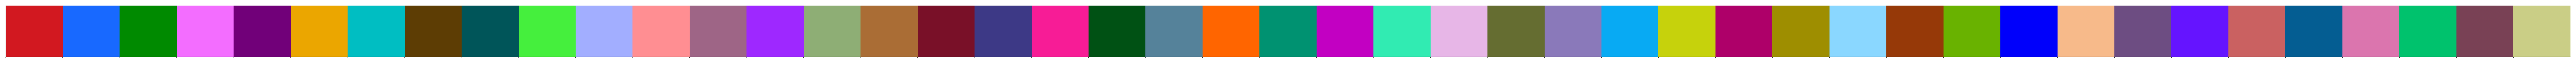

In [106]:
# %matplotlib inline
# # old one
# palette = glasbey.create_palette(
#     palette_size=len(unique_labels),
#     lightness_bounds=(20, 75),
#     chroma_bounds=(30, 90),
# )
# sns.palplot(palette)

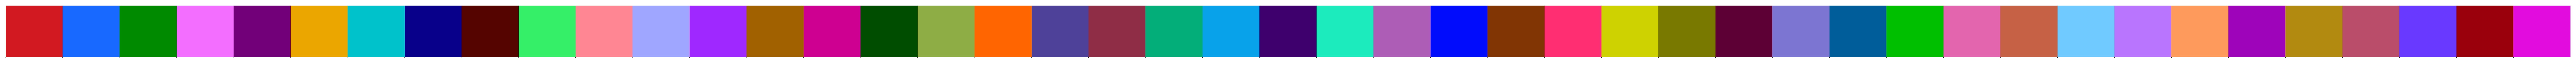

In [ ]:
# %matplotlib inline
# #v4
# palette = glasbey.create_palette(
#     palette_size=len(unique_labels),
#     lightness_bounds=(10, 75),
#     chroma_bounds=(50, 90),
# )
# sns.palplot(palette)

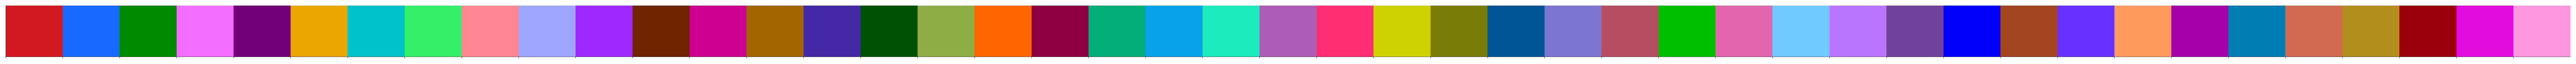

In [223]:
%matplotlib inline
palette = glasbey.create_palette(
    palette_size=len(unique_labels),
    lightness_bounds=(20, 75),
    chroma_bounds=(50, 90),
)
sns.palplot(palette)

In [226]:
dict_label_to_color = dict(zip(unique_labels, palette))
dict_label_to_color["unlabeled"] = "lightgrey"
dict_label_to_color

{'CNNs': '#d21820',
 'GANs': '#1869ff',
 'RNNs': '#008a00',
 'ViTs': '#f36dff',
 'active learning': '#710079',
 'adversarial': '#eba600',
 'anomaly detection': '#00c2ca',
 'autoencoders': '#35ef69',
 'causality': '#ff8692',
 'clustering': '#9ea6ff',
 'compression': '#9e28ff',
 'continual learning': '#712400',
 'contrastive learning': '#ce0092',
 'diffusion models': '#a26500',
 'explainability': '#4528a6',
 'fairness': '#005104',
 'federated learning': '#8eae45',
 'few-shot learning': '#ff6500',
 'graphs': '#8e0041',
 'imitation learning': '#04ae79',
 'in-context learning': '#08a2eb',
 'interpretability': '#1cebbe',
 'knowledge distillation': '#ae5db6',
 'language models': '#ff2d71',
 'llms': '#ced200',
 'meta learning': '#797d08',
 'model-based reinforcement learning': '#005596',
 'multi-agent reinforcement learning': '#7d75d2',
 'multi-task learning': '#b64d61',
 'neural architecture search': '#00be00',
 'object detection': '#e365ae',
 'offline RL': '#71caff',
 'optimal transport': '#

In [227]:
dict_label_to_color["LLMs"] = dict_label_to_color["llms"]
dict_label_to_color.pop("llms")
dict_label_to_color["RL"] = dict_label_to_color["reinforcement learning"]
dict_label_to_color.pop("reinforcement learning")
dict_label_to_color["model-based RL"] = dict_label_to_color[
    "model-based reinforcement learning"
]
dict_label_to_color.pop("model-based reinforcement learning")
dict_label_to_color["multi-agent RL"] = dict_label_to_color[
    "multi-agent reinforcement learning"
]
dict_label_to_color.pop("multi-agent reinforcement learning")
dict_label_to_color

{'CNNs': '#d21820',
 'GANs': '#1869ff',
 'RNNs': '#008a00',
 'ViTs': '#f36dff',
 'active learning': '#710079',
 'adversarial': '#eba600',
 'anomaly detection': '#00c2ca',
 'autoencoders': '#35ef69',
 'causality': '#ff8692',
 'clustering': '#9ea6ff',
 'compression': '#9e28ff',
 'continual learning': '#712400',
 'contrastive learning': '#ce0092',
 'diffusion models': '#a26500',
 'explainability': '#4528a6',
 'fairness': '#005104',
 'federated learning': '#8eae45',
 'few-shot learning': '#ff6500',
 'graphs': '#8e0041',
 'imitation learning': '#04ae79',
 'in-context learning': '#08a2eb',
 'interpretability': '#1cebbe',
 'knowledge distillation': '#ae5db6',
 'language models': '#ff2d71',
 'meta learning': '#797d08',
 'multi-task learning': '#b64d61',
 'neural architecture search': '#00be00',
 'object detection': '#e365ae',
 'offline RL': '#71caff',
 'optimal transport': '#ba75ff',
 'optimization': '#71419e',
 'out-of-distribution': '#0000fb',
 'privacy': '#a24520',
 'pruning': '#6931ff',
 '

In [228]:
def assign_labels_and_colors(
    data, keywords_and_freqs, dict_keyword_to_label, dict_color_legend=None
):
    """Assign labels and colors from list with lists of keywords.

    Parameters
    ----------
    data: list of lists, len (n_samples)
        List with lists of keywords for every paper.
    keywords_and_freqs: list of lists, len (n_labels)
        List of keywords groups. Contains all keywords and frequencies, with sublists of subgroups of keywords.
    dict_keyword_to_label: dict
        Dictionary assigning to each keyword its label (e.g. to all keywords in same subgroup same label).
    dict_color_legend: dict, len (n_labels)
        Dictionary assigning to each label a color.

    Returns
    -------
    labels: array, shape (n_samples,)
        Label for each paper.
    colors: array, shape (n_samples,)
        Color for each paper.


    """

    # prepare dict_freqs
    dict_freqs = dict(list(itertools.chain.from_iterable(keywords_and_freqs)))
    dict_freqs[
        "unlabeled"
    ] = 1e9  # assign very large value to unlabeled for argmax

    # clean empty lists of keywords from the data
    data_without_empty = [
        ["unlabeled"] if elem == [] else elem for elem in data
    ]

    # choose keywords for each paper
    chosen_keywords = []
    for list_keywords in data_without_empty:
        list_keywords_filtered = [
            elem if elem in set(dict_freqs.keys()) else "unlabeled"
            for elem in list_keywords
        ]

        freqs = np.vectorize(dict_freqs.get)(list_keywords_filtered)

        chosen_keyword = list_keywords_filtered[np.argmin(freqs)]
        chosen_keywords.append(chosen_keyword)

    chosen_keywords = np.array(chosen_keywords)

    # map chosen keywords to labels
    dict_keyword_to_label["unlabeled"] = "unlabeled"
    labels = np.vectorize(dict_keyword_to_label.get)(chosen_keywords)

    # colors
    colors = np.vectorize(dict_color_legend.get)(labels)

    return labels, colors

In [229]:
%%time
labels_iclr, colors_iclr = assign_labels_and_colors(
    iclr2024.keywords.to_list(),
    final_keywords_groups,
    dict_keyword_to_label,
    dict_label_to_color,
)

CPU times: user 645 ms, sys: 20.7 ms, total: 665 ms
Wall time: 642 ms


In [237]:
labels_iclr[labels_iclr == "RL"]

array(['RL', 'RL', 'RL', ..., 'RL', 'RL', 'RL'], dtype='<U26')

In [230]:
# np.save(variables_path / "updated_dataset" / "labels_iclr", labels_iclr)
np.save(variables_path / "updated_dataset" / "colors_iclr_2", colors_iclr)

f = open(
    variables_path / "updated_dataset" / "dict_label_to_color_2.pkl", "wb"
)
pickle.dump(dict_label_to_color, f)
f.close()

In [160]:
print(labels_iclr.shape)
print(type(labels_iclr))
print(colors_iclr.shape)
print(type(colors_iclr))

(24347,)
<class 'numpy.ndarray'>
(24347,)
<class 'numpy.ndarray'>


In [162]:
print(len(np.unique(labels_iclr)))
print(np.unique(labels_iclr))

46
['CNNs' 'GANs' 'RNNs' 'ViTs' 'active learning' 'adversarial'
 'anomaly detection' 'autoencoders' 'causality' 'clustering' 'compression'
 'continual learning' 'contrastive learning' 'diffusion models'
 'explainability' 'fairness' 'federated learning' 'few-shot learning'
 'graphs' 'imitation learning' 'in-context learning' 'interpretability'
 'knowledge distillation' 'language models' 'llms' 'meta learning'
 'model-based reinforcement learning' 'multi-agent reinforcement learning'
 'multi-task learning' 'neural architecture search' 'object detection'
 'offline RL' 'optimal transport' 'optimization' 'out-of-distribution'
 'privacy' 'pruning' 'reinforcement learning' 'robustness'
 'self-supervised learning' 'semi-supervised learning' 'time series'
 'transfer learning' 'transformers' 'unlabeled' 'vision-language models']


In [163]:
np.sum(labels_iclr == "unlabeled") / len(labels_iclr) * 100

46.61765309894443

In [171]:
labels_iclr.shape

(24347,)

In [170]:
np.sum(labels_iclr != "unlabeled")

12997

In [164]:
np.sum([1 if elem == [] else 0 for elem in iclr2024.keywords]) / len(
    labels_iclr
) * 100

8.752618392409744

In [165]:
7000 / 16000 * 100

43.75

In [166]:
np.save(variables_path / "updated_dataset" / "labels_iclr", labels_iclr)
np.save(variables_path / "updated_dataset" / "colors_iclr", colors_iclr)

f = open(variables_path / "updated_dataset" / "dict_label_to_color.pkl", "wb")
pickle.dump(dict_label_to_color, f)
f.close()

In [167]:
iclr2024.keywords.to_numpy()[labels_iclr == "unlabeled"][:50]

array([list([]), list(['theory', 'deep learning']),
       list(['unsupervised learning', 'applications', 'deep learning']),
       list([]), list([]), list([]), list(['deep learning']), list([]),
       list(['deep learning', 'unsupervised learning', 'structured prediction']),
       list(['applications']),
       list(['computer vision', 'unsupervised learning', 'deep learning']),
       list(['deep learning', 'supervised learning', 'speech', 'structured prediction']),
       list(['applications', 'deep learning']),
       list(['computer vision', 'deep learning']),
       list(['deep learning', 'applications']),
       list(['unsupervised learning', 'deep learning']),
       list(['computer vision', 'unsupervised learning']),
       list(['deep learning']), list(['deep learning', 'theory']),
       list(['deep learning', 'computer vision']),
       list(['deep learning', 'applications']),
       list(['deep learning', 'unsupervised learning', 'theory']),
       list([]), list(['deep

In [ ]:
list(['deep learning', 'unsupervised learning', 'structured prediction']),

list(['applications']),

list(['computer vision', 'unsupervised learning', 'deep learning']),

list(['deep learning', 'supervised learning', 'speech', 'structured prediction']),

list(['applications', 'deep learning']),

list(['computer vision', 'deep learning']),

list(['deep learning', 'applications']),

list(['unsupervised learning', 'deep learning']),

list(['computer vision', 'unsupervised learning']),

list(['deep learning']), list(['deep learning', 'theory']),

list(['deep learning', 'computer vision']),

list(['deep learning', 'applications']),

list(['deep learning', 'unsupervised learning', 'theory']),

list([]), list(['deep learning', 'theory']),

list(['deep learning']),

list(['computer vision', 'supervised learning']),


## Print latex table

In [44]:
# dict_keyword_to_label_test = {
#     ###### ADVERSARIAL
#     "adversarial": "adversarial",
#     "adversarial attack": "adversarial",
#     "adversarial attacks": "adversarial",
#     "adversarial defense": "adversarial",
#     "adversarial examples": "adversarial",
#     "adversarial learning": "adversarial",
#     "adversarial machine learning": "adversarial",
#     "adversarial robustness": "adversarial",
#     "adversarial training": "adversarial",
#     ###### TRANSFORMERS
#     "attention": "transformers",
#     "attention mechanism": "transformers",
#     "transformer": "transformers",
#     "transformers": "transformers",
#     "self-attention": "transformers",
#     "llm" : "LLMs",
# }

In [14]:
class_name, class_counts = np.unique(list(dict_keyword_to_label.values()), return_counts=True)

In [20]:
number_keywords_per_class = dict(zip(class_name,class_counts))
number_keywords_per_class["adversarial"]

9

In [49]:
# PRINT LATEX TABLE
star= "{*}"
previous_class_name = 0
for keyword, class_name in dict_keyword_to_label.items():
    if (class_name != previous_class_name) | (previous_class_name==0):  # first cell of class
        first_str= "{" + str(number_keywords_per_class[class_name]) + "}"
        if class_name[0].isupper():
            second_str= "{"+class_name+"}"
        else:
            second_str= "{"+class_name[0].upper()+class_name[1:]+"}"

        print("\midrule")
        print(f"\multirow{first_str}{star}{second_str} & {keyword}    \\\\ ")

    if class_name == previous_class_name:
        print(f"                      & {keyword} \\\\ ")

    previous_class_name = class_name
    

\midrule
\multirow{9}{*}{Adversarial} & adversarial    \\ 
                      & adversarial attack \\ 
                      & adversarial attacks \\ 
                      & adversarial defense \\ 
                      & adversarial examples \\ 
                      & adversarial learning \\ 
                      & adversarial machine learning \\ 
                      & adversarial robustness \\ 
                      & adversarial training \\ 
\midrule
\multirow{5}{*}{Transformers} & attention    \\ 
                      & attention mechanism \\ 
                      & transformer \\ 
                      & transformers \\ 
                      & self-attention \\ 
\midrule
\multirow{5}{*}{Autoencoders} & autoencoder    \\ 
                      & autoencoders \\ 
                      & vae \\ 
                      & variational autoencoder \\ 
                      & variational autoencoders \\ 
\midrule
\multirow{1}{*}{Anomaly detection} & anomaly detection    \\ 
\mid

\begin{table}[]
\begin{tabular}{@{}ll@{}}
\toprule
Class                 & Keyword        \\ \midrule

\multirow{3}{*}{LLMs} & transformer    \\
                      & language model \\
                      & llm            \\ \cmidrule(l){2-2} 
\end{tabular}
\end{table}

### Adding new columns

In [40]:
# dict_keyword_to_label_test = {
#     ###### ADVERSARIAL
#     "adversarial": "adversarial",
#     "adversarial attack": "adversarial",
#     "adversarial attacks": "adversarial",
#     "adversarial defense": "adversarial",
#     "adversarial examples": "adversarial",
#     "adversarial learning": "adversarial",
#     "adversarial machine learning": "adversarial",
#     "adversarial robustness": "adversarial",
#     "adversarial training": "adversarial",
#     ###### TRANSFORMERS
#     "attention": "transformers",
#     "attention mechanism": "transformers",
#     "transformer": "transformers",
#     "transformers": "transformers",
#     "self-attention": "transformers",
#     "llm": "LLMs",
# }
# len(dict_keyword_to_label_test)

#### create dataframe

In [41]:
df_table = pd.DataFrame(
    {
        "class_name": list(dict_keyword_to_label.values()),
        "keyword": list(dict_keyword_to_label.keys()),
    },
)

In [42]:
df_table

,class_name,keyword
0,adversarial,adversarial
1,adversarial,adversarial attack
2,adversarial,adversarial attacks
3,adversarial,adversarial defense
4,adversarial,adversarial examples
...,...,...
106,transfer learning,domain generalization
107,ViTs,vision transformer
108,ViTs,vision transformers
109,vision-language models,vision-language models


#### Add frequency per keyword

In [43]:
import itertools

dict_freqs = dict(list(itertools.chain.from_iterable(final_keywords_groups)))
dict_freqs

{'adversarial': 60,
 'adversarial attack': 121,
 'adversarial attacks': 106,
 'adversarial defense': 50,
 'adversarial examples': 196,
 'adversarial learning': 93,
 'adversarial machine learning': 54,
 'adversarial robustness': 241,
 'adversarial training': 217,
 'attention': 183,
 'attention mechanism': 53,
 'transformer': 340,
 'transformers': 261,
 'self-attention': 73,
 'autoencoder': 63,
 'autoencoders': 52,
 'vae': 71,
 'variational autoencoder': 93,
 'variational autoencoders': 83,
 'anomaly detection': 109,
 'causal discovery': 53,
 'causal inference': 104,
 'causality': 80,
 'clustering': 116,
 'compression': 121,
 'model compression': 135,
 'object detection': 125,
 'contrastive learning': 344,
 'convolutional neural network': 76,
 'convolutional neural networks': 130,
 'cnn': 88,
 'diffusion': 69,
 'diffusion model': 167,
 'diffusion models': 280,
 'explainability': 131,
 'explainable ai': 92,
 'interpretability': 356,
 'fairness': 182,
 'federated learning': 485,
 'generati

In [44]:
df_table["keyword_frequency"] = df_table["keyword"].map(dict_freqs)

In [45]:
df_table

,class_name,keyword,keyword_frequency
0,adversarial,adversarial,60
1,adversarial,adversarial attack,121
2,adversarial,adversarial attacks,106
3,adversarial,adversarial defense,50
4,adversarial,adversarial examples,196
...,...,...,...
106,transfer learning,domain generalization,124
107,ViTs,vision transformer,98
108,ViTs,vision transformers,51
109,vision-language models,vision-language models,48


#### Add n_samples per class

In [46]:
labels_iclr = np.load(variables_path / "updated_dataset" / "labels_iclr.npy")
# colors_iclr = np.load(variables_path / "updated_dataset" / "colors_iclr.npy")

# pickle_in = open(
#     variables_path / "updated_dataset" / "dict_label_to_color.pkl", "rb"
# )
# dict_label_to_color = pickle.load(pickle_in)

In [47]:
class_name_for_samples, class_n_samples = np.unique(
    labels_iclr, return_counts=True
)

In [48]:
dict_n_samples_per_class = dict(zip(class_name_for_samples, class_n_samples))
dict_n_samples_per_class

{'CNNs': 247,
 'GANs': 380,
 'RNNs': 250,
 'ViTs': 130,
 'active learning': 109,
 'adversarial': 868,
 'anomaly detection': 87,
 'autoencoders': 330,
 'causality': 200,
 'clustering': 97,
 'compression': 214,
 'continual learning': 313,
 'contrastive learning': 240,
 'diffusion models': 437,
 'explainability': 191,
 'fairness': 133,
 'federated learning': 297,
 'few-shot learning': 157,
 'graphs': 729,
 'imitation learning': 143,
 'in-context learning': 87,
 'interpretability': 177,
 'knowledge distillation': 149,
 'language models': 798,
 'llms': 534,
 'meta learning': 275,
 'model-based reinforcement learning': 105,
 'multi-agent reinforcement learning': 151,
 'multi-task learning': 121,
 'neural architecture search': 138,
 'object detection': 106,
 'offline RL': 184,
 'optimal transport': 132,
 'optimization': 785,
 'out-of-distribution': 272,
 'privacy': 214,
 'pruning': 133,
 'reinforcement learning': 1261,
 'robustness': 173,
 'self-supervised learning': 256,
 'semi-supervised le

In [71]:
dict_n_samples_per_class["LLMs"] = dict_n_samples_per_class["llms"]
dict_n_samples_per_class.pop("llms")
dict_n_samples_per_class["RL"] = dict_n_samples_per_class[
    "reinforcement learning"
]
dict_n_samples_per_class.pop("reinforcement learning")
dict_n_samples_per_class["model-based RL"] = dict_n_samples_per_class[
    "model-based reinforcement learning"
]
dict_n_samples_per_class.pop("model-based reinforcement learning")
dict_n_samples_per_class["multi-agent RL"] = dict_n_samples_per_class[
    "multi-agent reinforcement learning"
]
dict_n_samples_per_class.pop("multi-agent reinforcement learning")
dict_n_samples_per_class

{'CNNs': 247,
 'GANs': 380,
 'RNNs': 250,
 'ViTs': 130,
 'active learning': 109,
 'adversarial': 868,
 'anomaly detection': 87,
 'autoencoders': 330,
 'causality': 200,
 'clustering': 97,
 'compression': 214,
 'continual learning': 313,
 'contrastive learning': 240,
 'diffusion models': 437,
 'explainability': 191,
 'fairness': 133,
 'federated learning': 297,
 'few-shot learning': 157,
 'graphs': 729,
 'imitation learning': 143,
 'in-context learning': 87,
 'interpretability': 177,
 'knowledge distillation': 149,
 'language models': 798,
 'meta learning': 275,
 'multi-task learning': 121,
 'neural architecture search': 138,
 'object detection': 106,
 'offline RL': 184,
 'optimal transport': 132,
 'optimization': 785,
 'out-of-distribution': 272,
 'privacy': 214,
 'pruning': 133,
 'robustness': 173,
 'self-supervised learning': 256,
 'semi-supervised learning': 176,
 'time series': 140,
 'transfer learning': 417,
 'transformers': 555,
 'unlabeled': 11350,
 'vision-language models': 106

In [72]:
len(dict_n_samples_per_class)

46

In [74]:
df_table["n_samples"] = df_table["class_name"].map(dict_n_samples_per_class)

In [75]:
df_table

,class_name,keyword,keyword_frequency,n_samples,keywords_per_class
0,adversarial,adversarial,60,868,9
1,adversarial,adversarial attack,121,868,9
2,adversarial,adversarial attacks,106,868,9
3,adversarial,adversarial defense,50,868,9
4,adversarial,adversarial examples,196,868,9
...,...,...,...,...,...
106,transfer learning,domain generalization,124,417,3
107,ViTs,vision transformer,98,130,2
108,ViTs,vision transformers,51,130,2
109,vision-language models,vision-language models,48,106,2


####  Add number of keywords per class

In [51]:
class_name, class_counts = np.unique(
    list(dict_keyword_to_label.values()), return_counts=True
)

In [52]:
number_keywords_per_class = dict(zip(class_name, class_counts))
# fix for stupid difference in capitalizing or not due to diff in dict_keyword_to_label and dict_keyword_to_label_old (LLMs, RL, model-based RL, multi-agent RL)
number_keywords_per_class

{'CNNs': 3,
 'GANs': 4,
 'LLMs': 4,
 'RL': 2,
 'RNNs': 4,
 'ViTs': 2,
 'active learning': 1,
 'adversarial': 9,
 'anomaly detection': 1,
 'autoencoders': 5,
 'causality': 3,
 'clustering': 1,
 'compression': 2,
 'continual learning': 2,
 'contrastive learning': 1,
 'diffusion models': 3,
 'explainability': 2,
 'fairness': 1,
 'federated learning': 1,
 'few-shot learning': 1,
 'graphs': 5,
 'imitation learning': 1,
 'in-context learning': 1,
 'interpretability': 1,
 'knowledge distillation': 1,
 'language models': 8,
 'meta learning': 2,
 'model-based RL': 1,
 'multi-agent RL': 1,
 'multi-task learning': 1,
 'neural architecture search': 1,
 'object detection': 1,
 'offline RL': 2,
 'optimal transport': 1,
 'optimization': 9,
 'out-of-distribution': 4,
 'privacy': 2,
 'pruning': 2,
 'robustness': 1,
 'self-supervised learning': 1,
 'semi-supervised learning': 1,
 'time series': 2,
 'transfer learning': 3,
 'transformers': 5,
 'vision-language models': 2}

In [53]:
df_table["keywords_per_class"] = df_table["class_name"].map(
    number_keywords_per_class
)

In [61]:
df_table

,class_name,keyword,keyword_frequency,n_samples,keywords_per_class
0,adversarial,adversarial,60,868.0,9
1,adversarial,adversarial attack,121,868.0,9
2,adversarial,adversarial attacks,106,868.0,9
3,adversarial,adversarial defense,50,868.0,9
4,adversarial,adversarial examples,196,868.0,9
...,...,...,...,...,...
106,transfer learning,domain generalization,124,417.0,3
107,ViTs,vision transformer,98,130.0,2
108,ViTs,vision transformers,51,130.0,2
109,vision-language models,vision-language models,48,106.0,2


In [56]:
df_table.iloc[i].class_name

'transfer learning'

#### sort table by n_samples

In [81]:
df_table.sort_values(by="n_samples", ascending=False, inplace=True)

In [83]:
df_table

,class_name,keyword,keyword_frequency,n_samples,keywords_per_class
86,RL,reinforcement learning,1608,1261,2
87,RL,deep reinforcement learning,298,1261,2
8,adversarial,adversarial training,217,868,9
2,adversarial,adversarial attacks,106,868,9
3,adversarial,adversarial defense,50,868,9
...,...,...,...,...,...
26,object detection,object detection,125,106,1
89,model-based RL,model-based reinforcement learning,111,105,1
23,clustering,clustering,116,97,1
19,anomaly detection,anomaly detection,109,87,1


#### Print table

\begin{table}[]
\begin{tabular}{@{}ll@{}}
\toprule
Class                 &  N_SAMPLES               & Keyword        &  Frequency\\ \midrule
\multirow{3}{*}{LLMs} & \multirow{3}{*}{567}    & transformer    &  X\\
                      &                          & language model &  X\\
                      &                          & llm            &  X\\ \cmidrule(l){2-2} 
\end{tabular}
\end{table}

In [76]:
star = "{*}"
previous_class_name = 0
for i in np.arange(df_table.shape[0]):
    class_name = df_table.iloc[i].class_name
    keyword = df_table.iloc[i].keyword
    frequency = df_table.iloc[i].keyword_frequency

    if (class_name != previous_class_name) | (
        previous_class_name == 0
    ):  # first cell of class
        keywords_per_class_str = (
            "{" + str(df_table.iloc[i].keywords_per_class) + "}"
        )
        # class name
        if class_name[0].isupper():
            class_name_str = "{" + class_name + "}"
        else:
            class_name_str = "{" + class_name[0].upper() + class_name[1:] + "}"

        # n_samples
        n_samples_str = "{" + str(int(df_table.iloc[i].n_samples)) + "}"

        print("\midrule")
        print(
            f"\multirow{keywords_per_class_str}{star}{class_name_str} & \multirow{keywords_per_class_str}{star}{n_samples_str} & {keyword} & {frequency}    \\\\ "
        )

    if class_name == previous_class_name:
        print(f"                      &   &  {keyword} & {frequency} \\\\ ")

    previous_class_name = class_name

\midrule
\multirow{9}{*}{Adversarial} & \multirow{9}{*}{868} & adversarial & 60    \\ 
                      &   &  adversarial attack & 121 \\ 
                      &   &  adversarial attacks & 106 \\ 
                      &   &  adversarial defense & 50 \\ 
                      &   &  adversarial examples & 196 \\ 
                      &   &  adversarial learning & 93 \\ 
                      &   &  adversarial machine learning & 54 \\ 
                      &   &  adversarial robustness & 241 \\ 
                      &   &  adversarial training & 217 \\ 
\midrule
\multirow{5}{*}{Transformers} & \multirow{5}{*}{555} & attention & 183    \\ 
                      &   &  attention mechanism & 53 \\ 
                      &   &  transformer & 340 \\ 
                      &   &  transformers & 261 \\ 
                      &   &  self-attention & 73 \\ 
\midrule
\multirow{5}{*}{Autoencoders} & \multirow{5}{*}{330} & autoencoder & 63    \\ 
                      &   &  autoencoders

In [82]:
star = "{*}"
previous_class_name = 0
for i in np.arange(df_table.shape[0]):
    class_name = df_table.iloc[i].class_name
    keyword = df_table.iloc[i].keyword
    frequency = df_table.iloc[i].keyword_frequency

    if (class_name != previous_class_name) | (
        previous_class_name == 0
    ):  # first cell of class
        keywords_per_class_str = (
            "{" + str(df_table.iloc[i].keywords_per_class) + "}"
        )
        # class name
        if class_name[0].isupper():
            class_name_str = "{" + class_name + "}"
        else:
            class_name_str = "{" + class_name[0].upper() + class_name[1:] + "}"

        # n_samples
        n_samples_str = "{" + str(int(df_table.iloc[i].n_samples)) + "}"

        print("\midrule")
        print(
            f"\multirow{keywords_per_class_str}{star}{class_name_str} & \multirow{keywords_per_class_str}{star}{n_samples_str} & {keyword} & {frequency}    \\\\ "
        )

    if class_name == previous_class_name:
        print(f"                      &   &  {keyword} & {frequency} \\\\ ")

    previous_class_name = class_name

\midrule
\multirow{2}{*}{RL} & \multirow{2}{*}{1261} & reinforcement learning & 1608    \\ 
                      &   &  deep reinforcement learning & 298 \\ 
\midrule
\multirow{9}{*}{Adversarial} & \multirow{9}{*}{868} & adversarial training & 217    \\ 
                      &   &  adversarial attacks & 106 \\ 
                      &   &  adversarial defense & 50 \\ 
                      &   &  adversarial examples & 196 \\ 
                      &   &  adversarial learning & 93 \\ 
                      &   &  adversarial machine learning & 54 \\ 
                      &   &  adversarial robustness & 241 \\ 
                      &   &  adversarial & 60 \\ 
                      &   &  adversarial attack & 121 \\ 
\midrule
\multirow{8}{*}{Language models} & \multirow{8}{*}{798} & question answering & 59    \\ 
                      &   &  reasoning & 85 \\ 
                      &   &  language modeling & 85 \\ 
                      &   &  machine translation & 91 \\ 
           